In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/pos-1m-clean/1M_pos_clean_data.npy


In [2]:
import torch
print(torch.__version__)

2.1.2


In [3]:
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import pandas as pd

In [4]:
data = np.load('/kaggle/input/pos-1m-clean/1M_pos_clean_data.npy')
data.shape

(995978, 279)

In [5]:
test_ind = [1,10,100]
new_data = np.delete(data,test_ind,axis=0)
new_data.shape

(995975, 279)

In [6]:
train_data = new_data
new_spec = np.zeros_like(train_data[:,:271])
for i in range(len(train_data)):
    mean_sp = np.mean(train_data[i,:269])
    std_sp = np.std(train_data[i,:269])
    new_spec[i,:269] = (train_data[i,:269] - mean_sp) / std_sp
    new_spec[i,269] = mean_sp
    new_spec[i,270] = std_sp
#     new_spec[i,271] = train_data[i,269]   # rstar
#     new_spec[i,272] = train_data[i,270]   # rplanet
#     new_spec[i,273] = train_data[i,271]   # gp
new_spec.shape

(995975, 271)

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.optim.lr_scheduler import ExponentialLR

class GRUModel(nn.Module):
    def __init__(self ):
        super(GRUModel, self).__init__()
        self.gru1 = nn.GRU(input_size=X_train.shape[1], hidden_size=64, batch_first=True)
        self.gru2 = nn.GRU(64, hidden_size=128, num_layers=1, 
                            bidirectional=False, batch_first=True)
        self.gru3 = nn.GRU(128, hidden_size=256, num_layers=1, 
                            bidirectional=False, batch_first=True)
        self.gru4 = nn.GRU(256, hidden_size=128, num_layers=1, 
                            bidirectional=False, batch_first=True)
        self.dense = nn.Linear(128, 7)
    
    def forward(self, x):
        x, _ = self.gru1(x)
        x, _ = self.gru2(x)
        x, _ = self.gru3(x)
        x, _ = self.gru4(x)
        x = self.dense(x)
        return x

# R^2 loss function
class R2Loss(nn.Module):
    def __init__(self):
        super(R2Loss, self).__init__()

    def forward(self, y_pred, y_true):
        ss_res = torch.sum(torch.square(y_true - y_pred))
        ss_tot = torch.sum(torch.square(y_true - torch.mean(y_true)))
        r2 = 1 - ss_res / ss_tot
        return r2

## 10k Data

In [8]:
X = new_spec[:10000]
Y = new_data[:10000,272:]
X.shape, Y.shape

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
Y = scaler.fit_transform(Y)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20, random_state = 42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 271), (2000, 271), (8000, 7), (2000, 7))

In [9]:
initial_learning_rate = 1e-4
final_learning_rate = 1e-6
epochs = 100
train_size = X_train.shape[0]
batch_size = 32
lr_decay_factor = (final_learning_rate / initial_learning_rate)**(1/epochs)
steps_per_epoch = int(train_size/batch_size)
lr_decay_factor, steps_per_epoch

(0.954992586021436, 250)

In [10]:
net_10k = GRUModel()

input_size = (1,X_train.shape[1])
summary(net_10k, input_size)

Layer (type:depth-idx)                   Output Shape              Param #
GRUModel                                 [1, 7]                    --
├─GRU: 1-1                               [1, 64]                   64,704
├─GRU: 1-2                               [1, 128]                  74,496
├─GRU: 1-3                               [1, 256]                  296,448
├─GRU: 1-4                               [1, 128]                  148,224
├─Linear: 1-5                            [1, 7]                    903
Total params: 584,775
Trainable params: 584,775
Non-trainable params: 0
Total mult-adds (M): 108.54
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 2.34
Estimated Total Size (MB): 2.34

Epoch 1 loss: 0.967 R^2: 0.028 test_loss: 0.796 test_R^2: 0.208  
Epoch 2 loss: 0.605 R^2: 0.390 test_loss: 0.476 test_R^2: 0.526  
Epoch 3 loss: 0.447 R^2: 0.550 test_loss: 0.420 test_R^2: 0.582  
Epoch 4 loss: 0.390 R^2: 0.608 test_loss: 0.368 test_R^2: 0.634  
Epoch 5 loss: 0.350 R^2: 0.648 test_loss: 0.341 test_R^2: 0.661  
Epoch 6 loss: 0.326 R^2: 0.672 test_loss: 0.325 test_R^2: 0.677  
Epoch 7 loss: 0.310 R^2: 0.688 test_loss: 0.307 test_R^2: 0.695  
Epoch 8 loss: 0.297 R^2: 0.701 test_loss: 0.295 test_R^2: 0.707  
Epoch 9 loss: 0.286 R^2: 0.712 test_loss: 0.291 test_R^2: 0.711  
Epoch 10 loss: 0.277 R^2: 0.721 test_loss: 0.283 test_R^2: 0.719  
Epoch 11 loss: 0.267 R^2: 0.732 test_loss: 0.270 test_R^2: 0.731  
Epoch 12 loss: 0.259 R^2: 0.740 test_loss: 0.264 test_R^2: 0.737  
Epoch 13 loss: 0.252 R^2: 0.746 test_loss: 0.257 test_R^2: 0.744  
Epoch 14 loss: 0.247 R^2: 0.752 test_loss: 0.250 test_R^2: 0.751  
Epoch 15 loss: 0.241 R^2: 0.758 test_loss: 0.247 test_R^2: 0.754  
Epoc

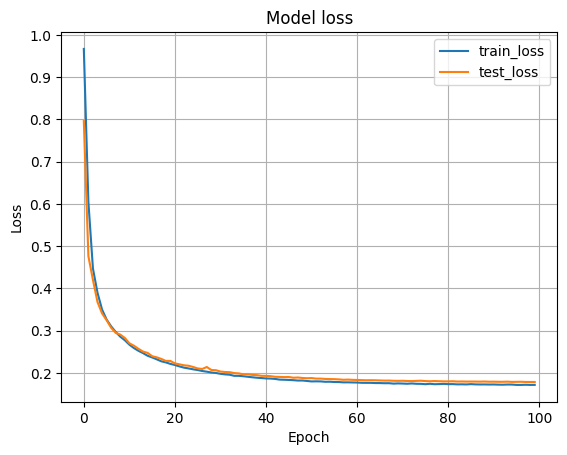

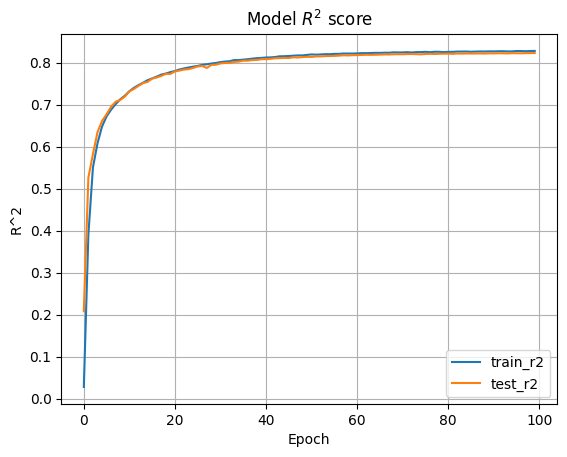

In [11]:
data = X_train
labels = y_train

data = torch.from_numpy(data).float()
labels = torch.from_numpy(labels).float()

trainset = torch.utils.data.TensorDataset(data, labels)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

criterion = nn.MSELoss()
optimizer = optim.Adam(net_10k.parameters(), lr=0.0001)
scheduler = ExponentialLR(optimizer,gamma=lr_decay_factor)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Training the neural network

epochs = 100

net_10k.to(device)
losses = []
r2s = []
test_losses = []
test_r2s = []
cur_lrs =[]
for epoch in range(epochs):
    net_10k.train()
    running_loss = 0.0
    running_r2 = 0.0
    for i, data in enumerate(trainloader, 0):
        
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net_10k(inputs)
        loss = criterion(outputs, labels)
        r2 = R2Loss()(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_r2 += r2.item()
    losses.append(running_loss / len(trainloader))
    r2s.append(running_r2 / len(trainloader))
#         print('Epoch %d loss: %.3f R^2: %.3f' % (epoch + 1, running_loss / len(trainloader), running_r2 / len(trainloader)))
    
    # Testing the neural network on the test data
    test_data = X_test
    test_labels = y_test
    test_data = torch.from_numpy(test_data).float()
    test_labels = torch.from_numpy(test_labels).float()
    net_10k.eval()
    with torch.no_grad():
        test_data, test_labels = test_data.to(device), test_labels.to(device)
        test_outputs = net_10k(test_data)
        test_loss = criterion(test_outputs, test_labels)
        test_r2 = R2Loss()(test_outputs, test_labels)
        test_losses.append(test_loss.item())
        test_r2s.append(test_r2.item())
    current_lr = optimizer.param_groups[0]['lr']
    cur_lrs.append(current_lr)
    print('Epoch %d loss: %.3f R^2: %.3f test_loss: %.3f test_R^2: %.3f  ' % (epoch + 1, running_loss / len(trainloader), running_r2 / len(trainloader), test_loss, test_r2))    
    scheduler.step()
    
# plotting model loss    
plt.plot(losses,label='train_loss')
plt.plot(test_losses, label='test_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model loss')
plt.legend()
plt.grid()
plt.show()
# plotting model r2 score
plt.plot(r2s, label='train_r2')
plt.plot(test_r2s, label='test_r2')
plt.xlabel('Epoch')
plt.ylabel('R^2')
plt.title('Model $R^{2}$ score')
plt.legend()
plt.grid()
plt.show()

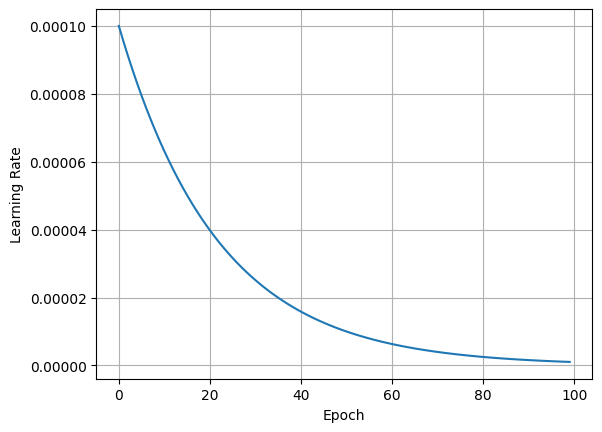

In [12]:
plt.plot( cur_lrs)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid()
plt.show()

In [13]:
path = '/kaggle/working/gru_10k_m_s'
torch.save(net_10k,path)

In [14]:
with torch.no_grad():
    test_data, test_labels = test_data.to(device), test_labels.to(device)
    test_outputs = net_10k(test_data)    
    pred = test_outputs
pred.shape

torch.Size([2000, 7])

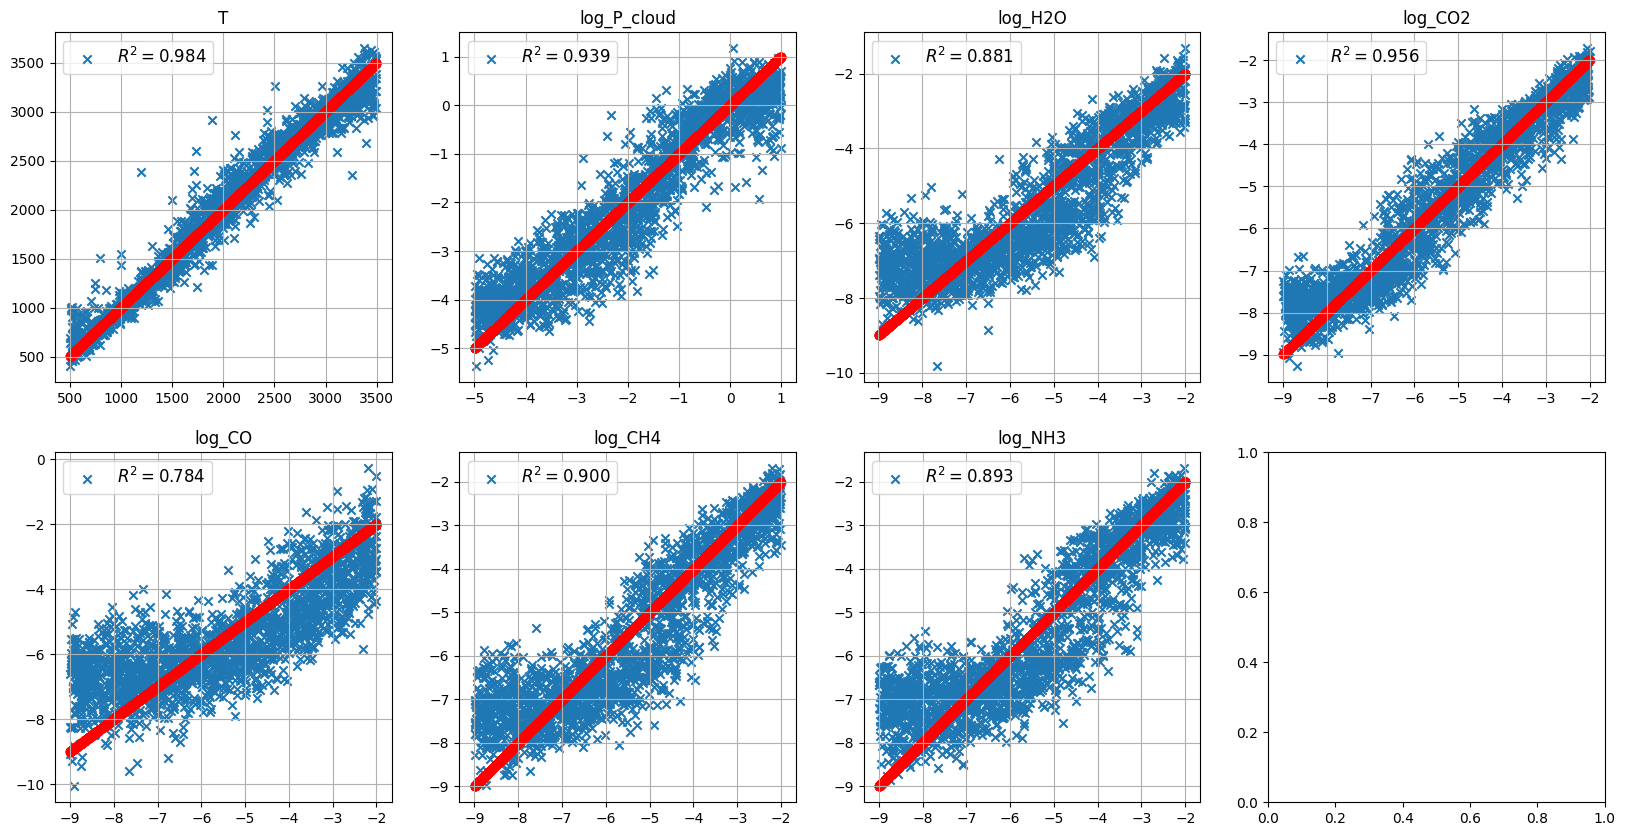

In [15]:
from scipy.stats import pearsonr

keys = ['T', 'log_P_cloud', 'log_H2O', 'log_CO2', 'log_CO', 'log_CH4', 'log_NH3']
fig, axs = plt.subplots(2, 4, figsize=(20,10))

y_test_rescaled = scaler.inverse_transform(y_test)
predictions = np.array(pred.cpu())
predictions = scaler.inverse_transform(predictions)

for i in range(7):
    if i < 4:
        corr, _ = pearsonr(predictions[:,i], y_test_rescaled[:,i])
        axs[0,i].scatter(y_test_rescaled[:,i],predictions[:,i], marker='x', label=f'$R^{2} = ${corr:.3f}')
        axs[0,i].scatter(y_test_rescaled[:,i],y_test_rescaled[:,i], color='red')
        axs[0,i].set_title(keys[i])
        axs[0,i].legend(loc='upper left',fontsize=12)
        axs[0,i].grid()
    else:
        corr, _ = pearsonr(predictions[:,i], y_test_rescaled[:,i])
        axs[1,i-4].scatter(y_test_rescaled[:,i],predictions[:,i], marker='x',label=f'$R^{2} = ${corr:.3f}')
        axs[1,i-4].scatter(y_test_rescaled[:,i],y_test_rescaled[:,i], color='red')
        axs[1,i-4].set_title(keys[i])
        axs[1,i-4].legend(loc= 'upper left',fontsize=12)
        axs[1,i-4].grid()

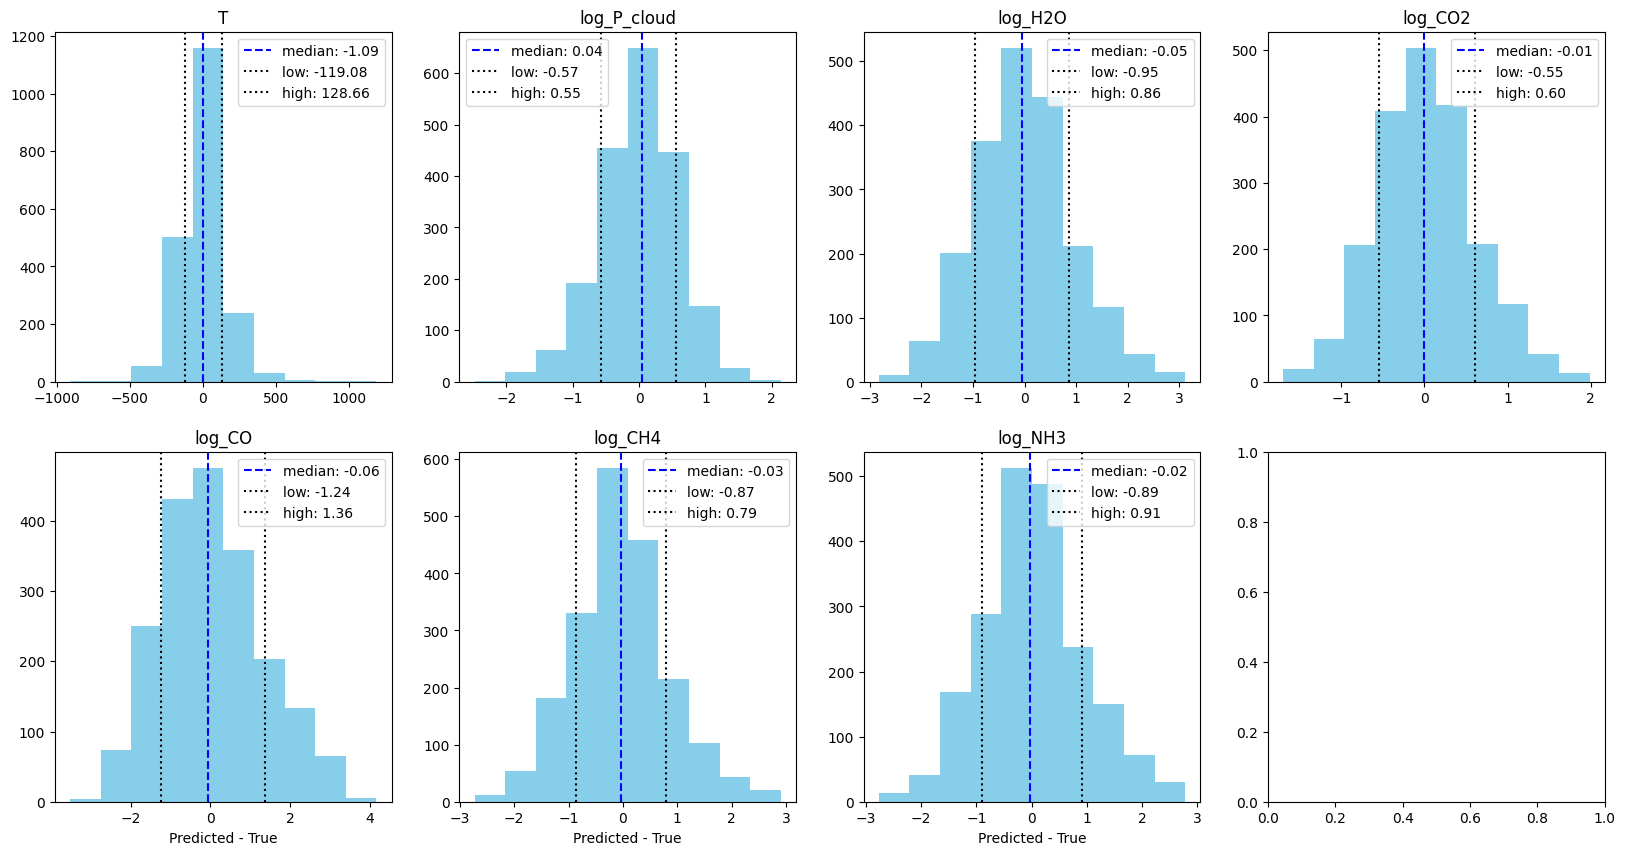

In [16]:
keys = ['T', 'log_P_cloud', 'log_H2O', 'log_CO2', 'log_CO', 'log_CH4', 'log_NH3']
fig, axs = plt.subplots(2, 4, figsize=(20,10))

y_test_rescaled = scaler.inverse_transform(y_test)
predictions = np.array(pred.cpu())
predictions = scaler.inverse_transform(predictions)

for i in range(7):
    if i < 4:
        pred_err = predictions[:,i]-y_test_rescaled[:,i]
        med = np.median(pred_err)
        low = np.percentile(pred_err,15.9)
        high = np.percentile(pred_err,84.1)
        axs[0,i].hist(pred_err,bins=10,color='skyblue')
        axs[0,i].axvline(x=med,color='blue',linestyle='--',label=f'median: {med:.2f}')
        axs[0,i].axvline(x=low,color='black',linestyle=':',label=f'low: {low:.2f}')
        axs[0,i].axvline(x=high,color='black',linestyle=':',label=f'high: {high:.2f}')
        axs[0,i].set_title(keys[i])
        axs[0,i].legend()
        #axs[0,i].set_xlabel('Predicted - True')
    else:
        pred_err = predictions[:,i]-y_test_rescaled[:,i]
        med = np.median(pred_err)
        low = np.percentile(pred_err,15.9)
        high = np.percentile(pred_err,84.1)
        axs[1,i-4].hist(pred_err,bins=10,color='skyblue')
        axs[1,i-4].axvline(x=med,color='blue',linestyle='--',label=f'median: {med:.2f}')
        axs[1,i-4].axvline(x=low,color='black',linestyle=':',label=f'low: {low:.2f}')
        axs[1,i-4].axvline(x=high,color='black',linestyle=':',label=f'high: {high:.2f}')
        axs[1,i-4].set_title(keys[i])
        axs[1,i-4].legend()
        axs[1,i-4].set_xlabel('Predicted - True')

In [17]:
y_test_rescaled_10k = scaler.inverse_transform(y_test)
predictions_10k = np.array(pred.cpu())
predictions_10k = scaler.inverse_transform(predictions_10k)

## Testing on the retreived planets

In [18]:
file_data = np.load('/kaggle/input/pos-1m-clean/1M_pos_clean_data.npy')

In [19]:
mean = np.mean(file_data[1,:269])
std = np.std(file_data[1,:269])
planetA_spec = (file_data[1,:269] - mean) / std
FH = np.max(file_data[1,:269]) - np.min(file_data[1,:269])
planetA_spec = np.concatenate([planetA_spec,np.array([mean]),np.array([std])])
#planetA_spec = np.concatenate([planetA_spec,np.array([mean]),np.array([std]),np.array([file_data[1,269]]), np.array([file_data[1,270]]), np.array([file_data[1,271]])])
planetA_params = file_data[1,269:]
planetA_spec.shape, planetA_params.shape

((271,), (10,))

In [20]:
mean = np.mean(file_data[10,:269])
std = np.std(file_data[10,:269])
planetB_spec = (file_data[10,:269] - mean) / std
FH = np.max(file_data[10,:269]) - np.min(file_data[10,:269])
planetB_spec = np.concatenate([planetB_spec,np.array([mean]),np.array([std])])
#planetB_spec = np.concatenate([planetB_spec,np.array([mean]),np.array([std]),np.array([file_data[10,269]]), np.array([file_data[10,270]]), np.array([file_data[10,271]])])
planetB_params = file_data[10,269:]
planetB_spec.shape, planetB_params.shape

((271,), (10,))

In [21]:
mean = np.mean(file_data[100,:269])
std = np.std(file_data[100,:269])
planetC_spec = (file_data[100,:269] - mean) / std
FH = np.max(file_data[100,:269]) - np.min(file_data[100,:269])
planetC_spec = np.concatenate([planetC_spec,np.array([mean]),np.array([std])])
#planetC_spec = np.concatenate([planetC_spec,np.array([mean]),np.array([std]),np.array([file_data[100,269]]), np.array([file_data[100,270]]), np.array([file_data[100,271]])])
planetC_params = file_data[100,269:]
planetC_spec.shape, planetC_params.shape

((271,), (10,))

In [22]:
test_planets = np.array([planetA_spec,planetB_spec,planetC_spec])
test_planets.shape

(3, 271)

In [23]:
pred_data = torch.from_numpy(test_planets).float()
with torch.no_grad():
    pred_data = pred_data.to(device)
    pred = net_10k(pred_data)    
pred = np.array(pred.cpu())    
pred.shape

(3, 7)

In [24]:
pred = scaler.inverse_transform(pred)
pred

array([[ 2.2057783e+03, -9.0741938e-01, -6.8575063e+00, -8.1343403e+00,
        -5.7261863e+00, -2.8427749e+00, -3.6346767e+00],
       [ 1.1580597e+03,  4.2102379e-01, -2.8076088e+00, -3.0381548e+00,
        -6.3330131e+00, -6.8350620e+00, -6.2753906e+00],
       [ 2.6157112e+03, -3.3886876e+00, -7.0101328e+00, -4.9662361e+00,
        -8.1062489e+00, -2.8371494e+00, -6.5611949e+00]], dtype=float32)

In [25]:
planetA_pred_10k = pred[0]
print("Predicted values:",planetA_pred_10k)
print("Actual values:",planetA_params[3:])

Predicted values: [ 2.2057783e+03 -9.0741938e-01 -6.8575063e+00 -8.1343403e+00
 -5.7261863e+00 -2.8427749e+00 -3.6346767e+00]
Actual values: [ 2.08383676e+03 -1.94865038e-01 -7.35204337e+00 -8.11423364e+00
 -5.01872241e+00 -3.65232765e+00 -4.16874130e+00]


In [26]:
planetB_pred_10k = pred[1]
print("Predicted values:",planetB_pred_10k)
print("Actual values:",planetB_params[3:])

Predicted values: [ 1.1580597e+03  4.2102379e-01 -2.8076088e+00 -3.0381548e+00
 -6.3330131e+00 -6.8350620e+00 -6.2753906e+00]
Actual values: [ 1.11335948e+03  1.70457392e-01 -2.78129766e+00 -2.70422089e+00
 -8.81511155e+00 -5.79890730e+00 -5.21304883e+00]


In [27]:
planetC_pred_10k = pred[2]
print("Predicted values:",planetC_pred_10k)
print("Actual values:",planetC_params[3:])

Predicted values: [2615.7112      -3.3886876   -7.010133    -4.966236    -8.106249
   -2.8371494   -6.561195 ]
Actual values: [ 2.66055847e+03 -3.48554752e+00 -5.39606516e+00 -5.07833705e+00
 -5.97777151e+00 -2.57789940e+00 -5.33643891e+00]


## 100k data

In [28]:
X = new_spec[:100000]
Y = new_data[:100000,272:]
X.shape, Y.shape

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
Y = scaler.fit_transform(Y)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20, random_state = 42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((80000, 271), (20000, 271), (80000, 7), (20000, 7))

In [29]:
initial_learning_rate = 1e-4
final_learning_rate = 1e-6
epochs = 100
train_size = X_train.shape[0]
batch_size = 32
lr_decay_factor = (final_learning_rate / initial_learning_rate)**(1/epochs)
steps_per_epoch = int(train_size/batch_size)
lr_decay_factor, steps_per_epoch

(0.954992586021436, 2500)

In [30]:
net_100k = GRUModel()

input_size = (1,X_train.shape[1])
summary(net_100k, input_size)

Layer (type:depth-idx)                   Output Shape              Param #
GRUModel                                 [1, 7]                    --
├─GRU: 1-1                               [1, 64]                   64,704
├─GRU: 1-2                               [1, 128]                  74,496
├─GRU: 1-3                               [1, 256]                  296,448
├─GRU: 1-4                               [1, 128]                  148,224
├─Linear: 1-5                            [1, 7]                    903
Total params: 584,775
Trainable params: 584,775
Non-trainable params: 0
Total mult-adds (M): 108.54
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 2.34
Estimated Total Size (MB): 2.34

Epoch 1 loss: 0.412 R^2: 0.586 test_loss: 0.252 test_R^2: 0.747  
Epoch 2 loss: 0.221 R^2: 0.778 test_loss: 0.205 test_R^2: 0.795  
Epoch 3 loss: 0.180 R^2: 0.819 test_loss: 0.164 test_R^2: 0.836  
Epoch 4 loss: 0.158 R^2: 0.842 test_loss: 0.157 test_R^2: 0.843  
Epoch 5 loss: 0.142 R^2: 0.857 test_loss: 0.136 test_R^2: 0.864  
Epoch 6 loss: 0.131 R^2: 0.868 test_loss: 0.131 test_R^2: 0.869  
Epoch 7 loss: 0.123 R^2: 0.877 test_loss: 0.114 test_R^2: 0.885  
Epoch 8 loss: 0.116 R^2: 0.883 test_loss: 0.116 test_R^2: 0.884  
Epoch 9 loss: 0.111 R^2: 0.889 test_loss: 0.106 test_R^2: 0.894  
Epoch 10 loss: 0.106 R^2: 0.893 test_loss: 0.105 test_R^2: 0.895  
Epoch 11 loss: 0.103 R^2: 0.897 test_loss: 0.100 test_R^2: 0.900  
Epoch 12 loss: 0.099 R^2: 0.900 test_loss: 0.100 test_R^2: 0.900  
Epoch 13 loss: 0.096 R^2: 0.903 test_loss: 0.099 test_R^2: 0.901  
Epoch 14 loss: 0.094 R^2: 0.906 test_loss: 0.095 test_R^2: 0.905  
Epoch 15 loss: 0.092 R^2: 0.908 test_loss: 0.090 test_R^2: 0.910  
Epoc

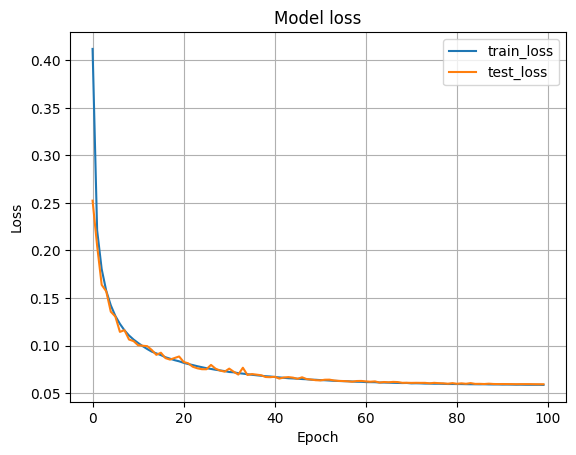

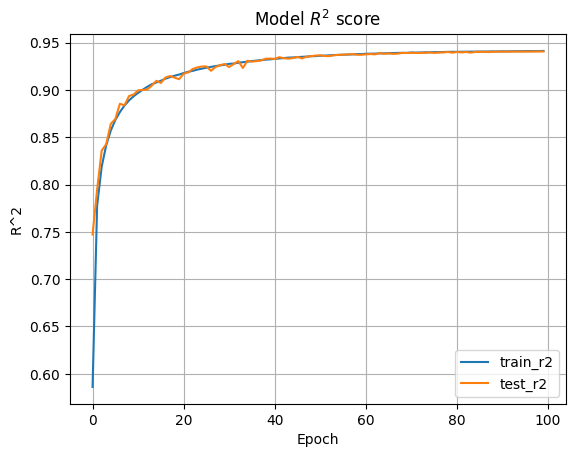

In [31]:
data = X_train
labels = y_train

data = torch.from_numpy(data).float()
labels = torch.from_numpy(labels).float()

trainset = torch.utils.data.TensorDataset(data, labels)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

criterion = nn.MSELoss()
optimizer = optim.Adam(net_100k.parameters(), lr=0.0001)
scheduler = ExponentialLR(optimizer,gamma=lr_decay_factor)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Training the neural network

epochs = 100

net_100k.to(device)
losses = []
r2s = []
test_losses = []
test_r2s = []
cur_lrs =[]
for epoch in range(epochs):
    net_100k.train()
    running_loss = 0.0
    running_r2 = 0.0
    for i, data in enumerate(trainloader, 0):
        
        
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net_100k(inputs)
        loss = criterion(outputs, labels)
        r2 = R2Loss()(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_r2 += r2.item()
    losses.append(running_loss / len(trainloader))
    r2s.append(running_r2 / len(trainloader))
#         print('Epoch %d loss: %.3f R^2: %.3f' % (epoch + 1, running_loss / len(trainloader), running_r2 / len(trainloader)))
    # Testing the neural network on the test data
    test_data = X_test
    test_labels = y_test
    test_data = torch.from_numpy(test_data).float()
    test_labels = torch.from_numpy(test_labels).float()
    net_100k.eval()
    with torch.no_grad():
        test_data, test_labels = test_data.to(device), test_labels.to(device)
        test_outputs = net_100k(test_data)
        test_loss = criterion(test_outputs, test_labels)
        test_r2 = R2Loss()(test_outputs, test_labels)
        test_losses.append(test_loss.item())
        test_r2s.append(test_r2.item())
    current_lr = optimizer.param_groups[0]['lr']
    cur_lrs.append(current_lr)
    print('Epoch %d loss: %.3f R^2: %.3f test_loss: %.3f test_R^2: %.3f  ' % (epoch + 1, running_loss / len(trainloader), running_r2 / len(trainloader), test_loss, test_r2))    
    scheduler.step()
    
# plotting model loss    
plt.plot(losses,label='train_loss')
plt.plot(test_losses, label='test_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model loss')
plt.legend()
plt.grid()
plt.show()
# plotting model r2 score
plt.plot(r2s, label='train_r2')
plt.plot(test_r2s, label='test_r2')
plt.xlabel('Epoch')
plt.ylabel('R^2')
plt.title('Model $R^{2}$ score')
plt.legend()
plt.grid()
plt.show()

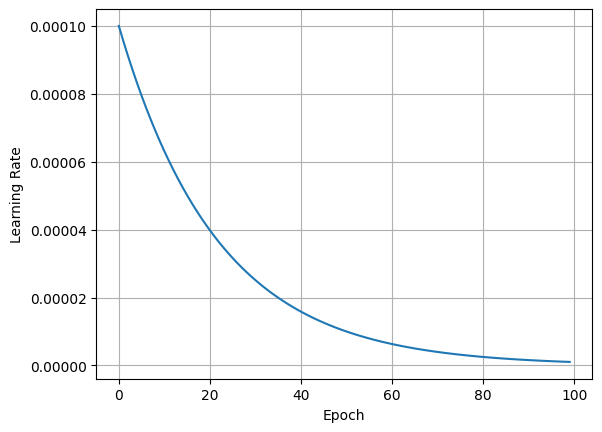

In [32]:
plt.plot( cur_lrs)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid()
plt.show()

In [33]:
path = '/kaggle/working/gru_100k_m_s'
torch.save(net_100k,path)

In [34]:
with torch.no_grad():
    test_data, test_labels = test_data.to(device), test_labels.to(device)
    test_outputs = net_100k(test_data)    
    pred = test_outputs
pred.shape

torch.Size([20000, 7])

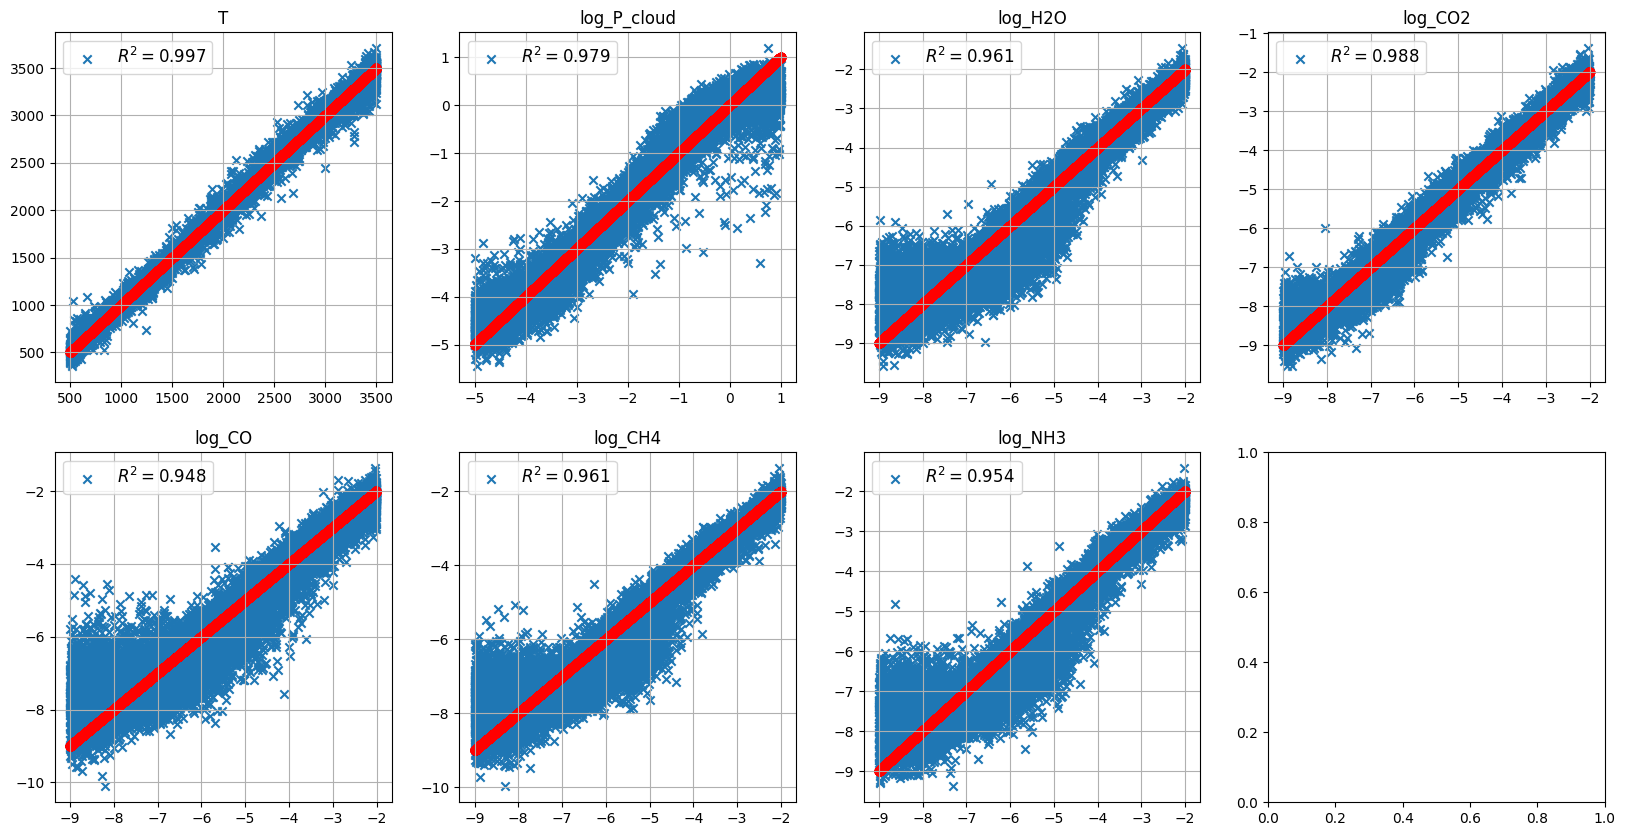

In [35]:
from scipy.stats import pearsonr

keys = ['T', 'log_P_cloud', 'log_H2O', 'log_CO2', 'log_CO', 'log_CH4', 'log_NH3']
fig, axs = plt.subplots(2, 4, figsize=(20,10))

y_test_rescaled = scaler.inverse_transform(y_test)
predictions = np.array(pred.cpu())
predictions = scaler.inverse_transform(predictions)

for i in range(7):
    if i < 4:
        corr, _ = pearsonr(predictions[:,i], y_test_rescaled[:,i])
        axs[0,i].scatter(y_test_rescaled[:,i],predictions[:,i], marker='x', label=f'$R^{2} = ${corr:.3f}')
        axs[0,i].scatter(y_test_rescaled[:,i],y_test_rescaled[:,i], color='red')
        axs[0,i].set_title(keys[i])
        axs[0,i].legend(loc='upper left',fontsize=12)
        axs[0,i].grid()
    else:
        corr, _ = pearsonr(predictions[:,i], y_test_rescaled[:,i])
        axs[1,i-4].scatter(y_test_rescaled[:,i],predictions[:,i], marker='x',label=f'$R^{2} = ${corr:.3f}')
        axs[1,i-4].scatter(y_test_rescaled[:,i],y_test_rescaled[:,i], color='red')
        axs[1,i-4].set_title(keys[i])
        axs[1,i-4].legend(loc= 'upper left',fontsize=12)
        axs[1,i-4].grid()

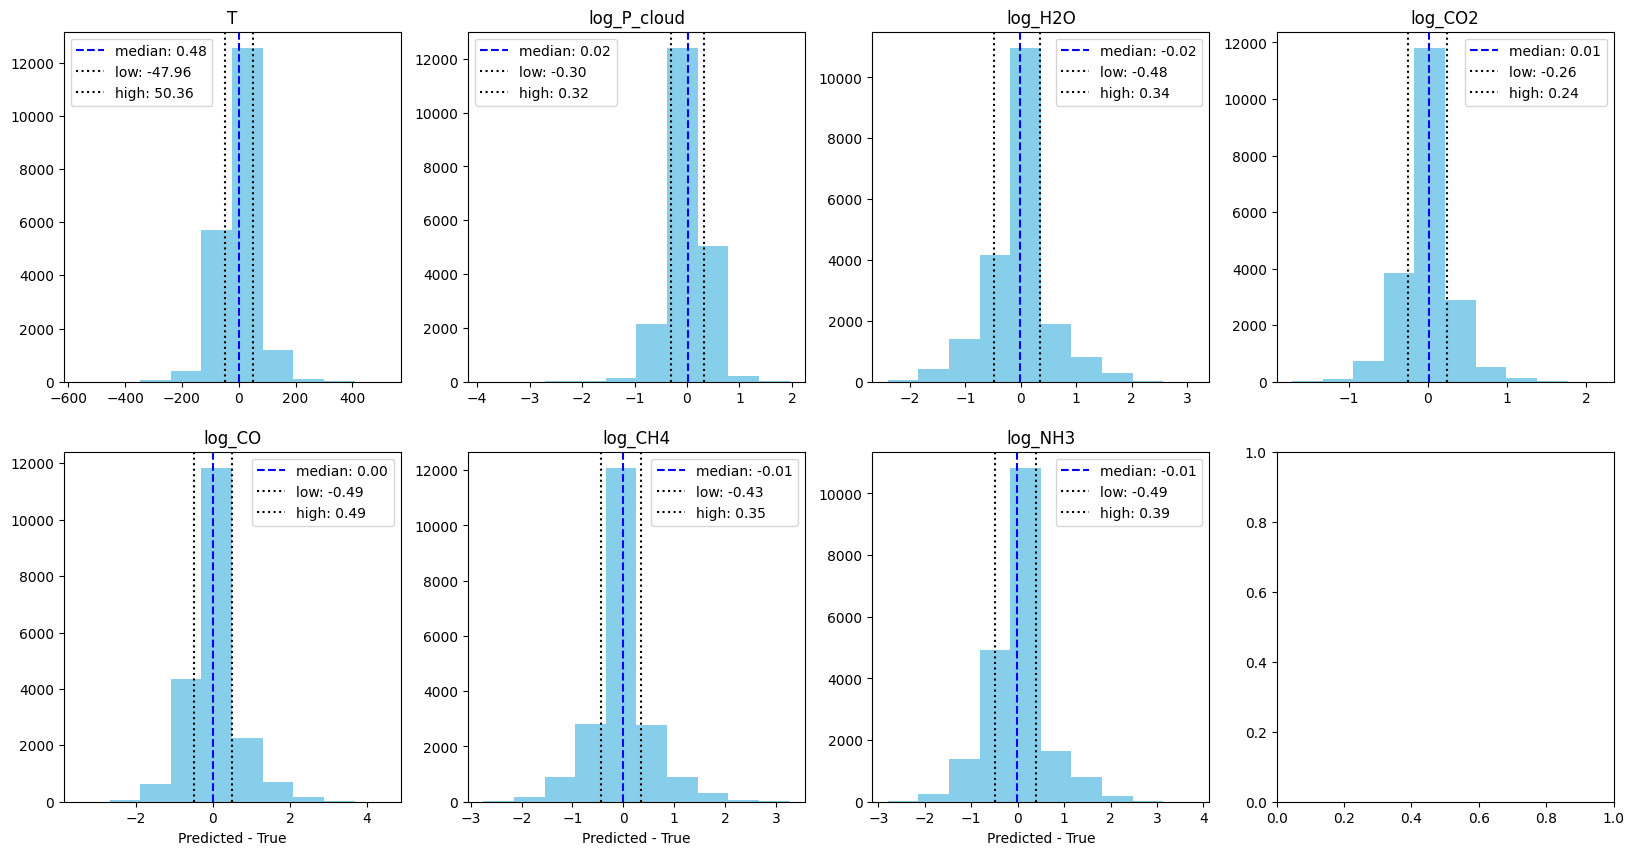

In [36]:
keys = ['T', 'log_P_cloud', 'log_H2O', 'log_CO2', 'log_CO', 'log_CH4', 'log_NH3']
fig, axs = plt.subplots(2, 4, figsize=(20,10))

y_test_rescaled = scaler.inverse_transform(y_test)
predictions = np.array(pred.cpu())
predictions = scaler.inverse_transform(predictions)

for i in range(7):
    if i < 4:
        pred_err = predictions[:,i]-y_test_rescaled[:,i]
        med = np.median(pred_err)
        low = np.percentile(pred_err,15.9)
        high = np.percentile(pred_err,84.1)
        axs[0,i].hist(pred_err,bins=10,color='skyblue')
        axs[0,i].axvline(x=med,color='blue',linestyle='--',label=f'median: {med:.2f}')
        axs[0,i].axvline(x=low,color='black',linestyle=':',label=f'low: {low:.2f}')
        axs[0,i].axvline(x=high,color='black',linestyle=':',label=f'high: {high:.2f}')
        axs[0,i].set_title(keys[i])
        axs[0,i].legend()
        #axs[0,i].set_xlabel('Predicted - True')
    else:
        pred_err = predictions[:,i]-y_test_rescaled[:,i]
        med = np.median(pred_err)
        low = np.percentile(pred_err,15.9)
        high = np.percentile(pred_err,84.1)
        axs[1,i-4].hist(pred_err,bins=10,color='skyblue')
        axs[1,i-4].axvline(x=med,color='blue',linestyle='--',label=f'median: {med:.2f}')
        axs[1,i-4].axvline(x=low,color='black',linestyle=':',label=f'low: {low:.2f}')
        axs[1,i-4].axvline(x=high,color='black',linestyle=':',label=f'high: {high:.2f}')
        axs[1,i-4].set_title(keys[i])
        axs[1,i-4].legend()
        axs[1,i-4].set_xlabel('Predicted - True')

In [37]:
y_test_rescaled_100k = scaler.inverse_transform(y_test)
predictions_100k = np.array(pred.cpu())
predictions_100k = scaler.inverse_transform(predictions_100k)

In [38]:
pred_data = torch.from_numpy(test_planets).float()
with torch.no_grad():
    pred_data = pred_data.to(device)
    pred = net_100k(pred_data)    
pred = np.array(pred.cpu())    
pred = scaler.inverse_transform(pred)
pred

array([[ 2.0680337e+03,  1.1419751e-01, -7.5418515e+00, -8.4723625e+00,
        -4.7890606e+00, -3.7450585e+00, -4.1679997e+00],
       [ 1.0517062e+03,  1.3665010e-01, -2.7414117e+00, -2.3795779e+00,
        -7.6079073e+00, -5.6309948e+00, -5.0645690e+00],
       [ 2.5658159e+03, -3.4973640e+00, -6.2825089e+00, -5.4984431e+00,
        -7.4830127e+00, -2.9163589e+00, -6.6817584e+00]], dtype=float32)

In [39]:
planetA_pred_100k = pred[0]
print("Predicted values:",planetA_pred_100k)
print("Actual values:",planetA_params[3:])

Predicted values: [ 2.0680337e+03  1.1419751e-01 -7.5418515e+00 -8.4723625e+00
 -4.7890606e+00 -3.7450585e+00 -4.1679997e+00]
Actual values: [ 2.08383676e+03 -1.94865038e-01 -7.35204337e+00 -8.11423364e+00
 -5.01872241e+00 -3.65232765e+00 -4.16874130e+00]


In [40]:
planetB_pred_100k = pred[1]
print("Predicted values:",planetB_pred_100k)
print("Actual values:",planetB_params[3:])

Predicted values: [ 1.0517062e+03  1.3665010e-01 -2.7414117e+00 -2.3795779e+00
 -7.6079073e+00 -5.6309948e+00 -5.0645690e+00]
Actual values: [ 1.11335948e+03  1.70457392e-01 -2.78129766e+00 -2.70422089e+00
 -8.81511155e+00 -5.79890730e+00 -5.21304883e+00]


In [41]:
planetC_pred_100k = pred[2]
print("Predicted values:",planetC_pred_100k)
print("Actual values:",planetC_params[3:])

Predicted values: [2565.816       -3.497364    -6.282509    -5.498443    -7.4830127
   -2.916359    -6.6817584]
Actual values: [ 2.66055847e+03 -3.48554752e+00 -5.39606516e+00 -5.07833705e+00
 -5.97777151e+00 -2.57789940e+00 -5.33643891e+00]


## 1M data

In [42]:
X = new_spec
Y = new_data[:,272:]
X.shape, Y.shape

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
Y = scaler.fit_transform(Y)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20, random_state = 42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((796780, 271), (199195, 271), (796780, 7), (199195, 7))

In [43]:
initial_learning_rate = 1e-4
final_learning_rate = 1e-6
epochs = 100
train_size = X_train.shape[0]
batch_size = 32
lr_decay_factor = (final_learning_rate / initial_learning_rate)**(1/epochs)
steps_per_epoch = int(train_size/batch_size)
lr_decay_factor, steps_per_epoch

(0.954992586021436, 24899)

In [44]:
net_1m = GRUModel()

input_size = (1,X_train.shape[1])
summary(net_1m, input_size)

Layer (type:depth-idx)                   Output Shape              Param #
GRUModel                                 [1, 7]                    --
├─GRU: 1-1                               [1, 64]                   64,704
├─GRU: 1-2                               [1, 128]                  74,496
├─GRU: 1-3                               [1, 256]                  296,448
├─GRU: 1-4                               [1, 128]                  148,224
├─Linear: 1-5                            [1, 7]                    903
Total params: 584,775
Trainable params: 584,775
Non-trainable params: 0
Total mult-adds (M): 108.54
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 2.34
Estimated Total Size (MB): 2.34

Epoch 1 loss: 0.167 R^2: 0.832 test_loss: 0.098 test_R^2: 0.902  
Epoch 2 loss: 0.090 R^2: 0.910 test_loss: 0.077 test_R^2: 0.923  
Epoch 3 loss: 0.075 R^2: 0.925 test_loss: 0.071 test_R^2: 0.929  
Epoch 4 loss: 0.067 R^2: 0.932 test_loss: 0.062 test_R^2: 0.938  
Epoch 5 loss: 0.062 R^2: 0.937 test_loss: 0.058 test_R^2: 0.942  
Epoch 6 loss: 0.058 R^2: 0.941 test_loss: 0.055 test_R^2: 0.945  
Epoch 7 loss: 0.056 R^2: 0.944 test_loss: 0.056 test_R^2: 0.944  
Epoch 8 loss: 0.053 R^2: 0.947 test_loss: 0.050 test_R^2: 0.950  
Epoch 9 loss: 0.051 R^2: 0.949 test_loss: 0.047 test_R^2: 0.953  
Epoch 10 loss: 0.049 R^2: 0.950 test_loss: 0.048 test_R^2: 0.952  
Epoch 11 loss: 0.048 R^2: 0.952 test_loss: 0.043 test_R^2: 0.957  
Epoch 12 loss: 0.046 R^2: 0.954 test_loss: 0.045 test_R^2: 0.955  
Epoch 13 loss: 0.045 R^2: 0.955 test_loss: 0.045 test_R^2: 0.955  
Epoch 14 loss: 0.044 R^2: 0.956 test_loss: 0.042 test_R^2: 0.958  
Epoch 15 loss: 0.043 R^2: 0.957 test_loss: 0.041 test_R^2: 0.959  
Epoc

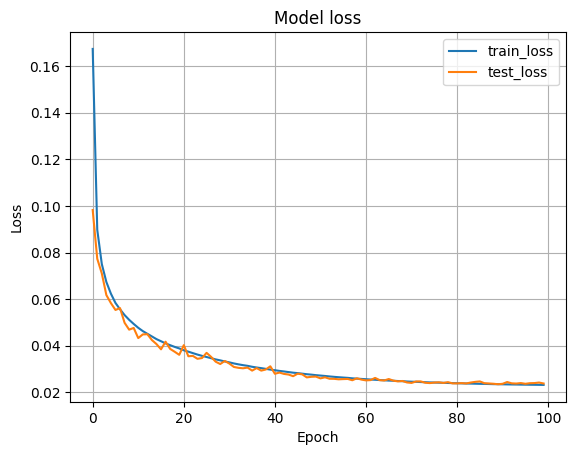

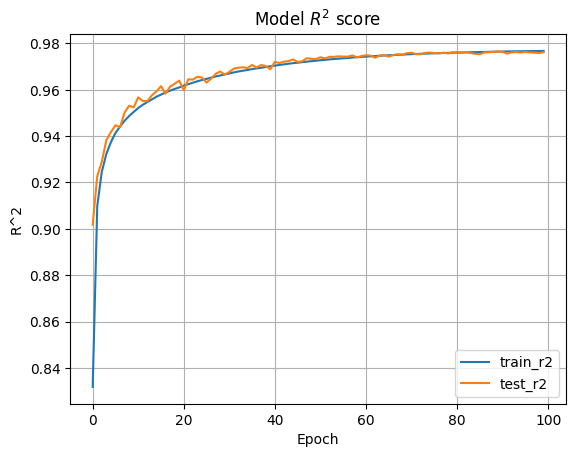

In [45]:
data = X_train
labels = y_train

data = torch.from_numpy(data).float()
labels = torch.from_numpy(labels).float()

trainset = torch.utils.data.TensorDataset(data, labels)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

criterion = nn.MSELoss()
optimizer = optim.Adam(net_1m.parameters(), lr=0.0001)
scheduler = ExponentialLR(optimizer,gamma=lr_decay_factor)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Train the neural network

epochs = 100

net_1m.to(device)
losses = []
r2s = []
test_losses = []
test_r2s = []
cur_lrs =[]
for epoch in range(epochs):
    net_1m.train()
    running_loss = 0.0
    running_r2 = 0.0
    for i, data in enumerate(trainloader, 0):
        
        
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net_1m(inputs)
        loss = criterion(outputs, labels)
        r2 = R2Loss()(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_r2 += r2.item()
    losses.append(running_loss / len(trainloader))
    r2s.append(running_r2 / len(trainloader))
#         print('Epoch %d loss: %.3f R^2: %.3f' % (epoch + 1, running_loss / len(trainloader), running_r2 / len(trainloader)))
    
    # Testing the neural network on the test data
    test_data = X_test
    test_labels = y_test
    test_data = torch.from_numpy(test_data).float()
    test_labels = torch.from_numpy(test_labels).float()
    net_1m.eval()
    with torch.no_grad():
        test_data, test_labels = test_data.to(device), test_labels.to(device)
        test_outputs = net_1m(test_data)
        test_loss = criterion(test_outputs, test_labels)
        test_r2 = R2Loss()(test_outputs, test_labels)
        test_losses.append(test_loss.item())
        test_r2s.append(test_r2.item())
    current_lr = optimizer.param_groups[0]['lr']
    cur_lrs.append(current_lr)
    print('Epoch %d loss: %.3f R^2: %.3f test_loss: %.3f test_R^2: %.3f  ' % (epoch + 1, running_loss / len(trainloader), running_r2 / len(trainloader), test_loss, test_r2))    
    scheduler.step()
    
# plotting model loss    
plt.plot(losses,label='train_loss')
plt.plot(test_losses, label='test_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model loss')
plt.legend()
plt.grid()
plt.show()
# plotting model r2 score
plt.plot(r2s, label='train_r2')
plt.plot(test_r2s, label='test_r2')
plt.xlabel('Epoch')
plt.ylabel('R^2')
plt.title('Model $R^{2}$ score')
plt.legend()
plt.grid()
plt.show()

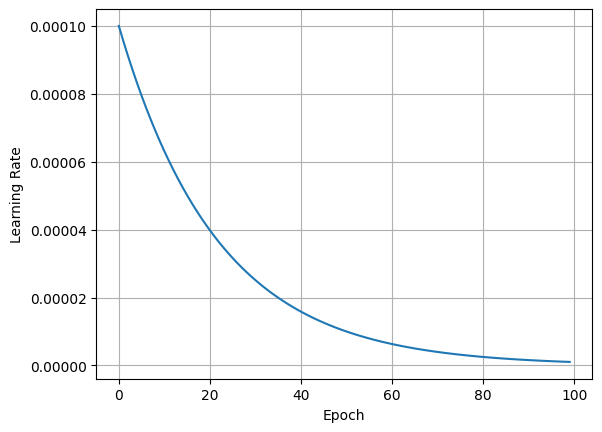

In [46]:
plt.plot( cur_lrs)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid()
plt.show()

In [47]:
path = '/kaggle/working/gru_1M_m_s'
torch.save(net_1m,path)

In [48]:
with torch.no_grad():
    test_data, test_labels = test_data.to(device), test_labels.to(device)
    test_outputs = net_1m(test_data)    
    pred = test_outputs
pred.shape

torch.Size([199195, 7])

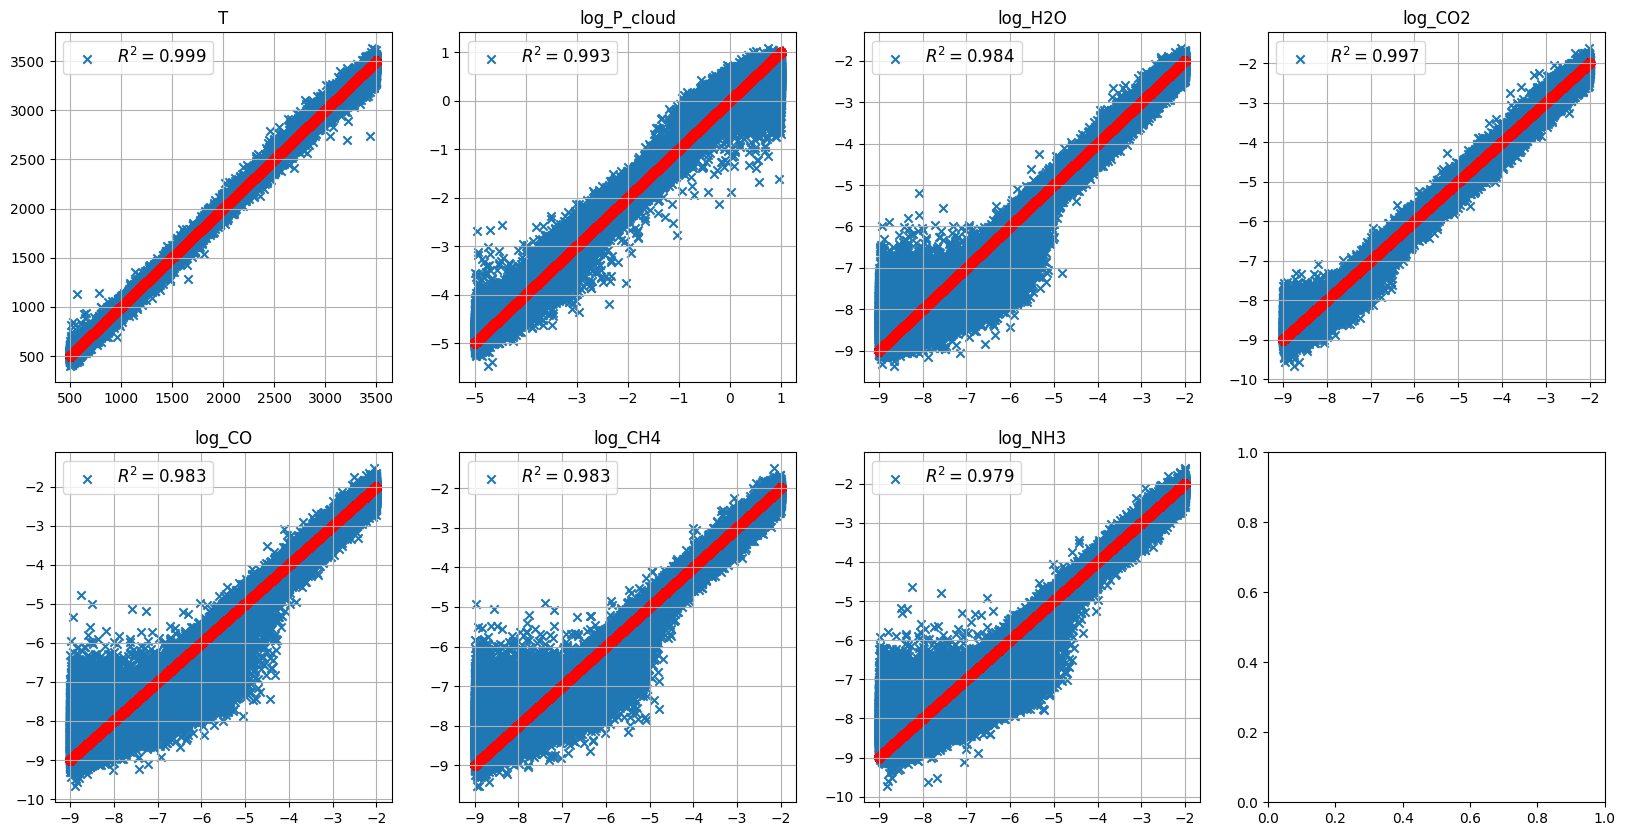

In [49]:
from scipy.stats import pearsonr

keys = ['T', 'log_P_cloud', 'log_H2O', 'log_CO2', 'log_CO', 'log_CH4', 'log_NH3']
fig, axs = plt.subplots(2, 4, figsize=(20,10))

y_test_rescaled = scaler.inverse_transform(y_test)
predictions = np.array(pred.cpu())
predictions = scaler.inverse_transform(predictions)

for i in range(7):
    if i < 4:
        corr, _ = pearsonr(predictions[:,i], y_test_rescaled[:,i])
        axs[0,i].scatter(y_test_rescaled[:,i],predictions[:,i], marker='x', label=f'$R^{2} = ${corr:.3f}')
        axs[0,i].scatter(y_test_rescaled[:,i],y_test_rescaled[:,i], color='red')
        axs[0,i].set_title(keys[i])
        axs[0,i].legend(loc='upper left',fontsize=12)
        axs[0,i].grid()
    else:
        corr, _ = pearsonr(predictions[:,i], y_test_rescaled[:,i])
        axs[1,i-4].scatter(y_test_rescaled[:,i],predictions[:,i], marker='x',label=f'$R^{2} = ${corr:.3f}')
        axs[1,i-4].scatter(y_test_rescaled[:,i],y_test_rescaled[:,i], color='red')
        axs[1,i-4].set_title(keys[i])
        axs[1,i-4].legend(loc= 'upper left',fontsize=12)
        axs[1,i-4].grid()

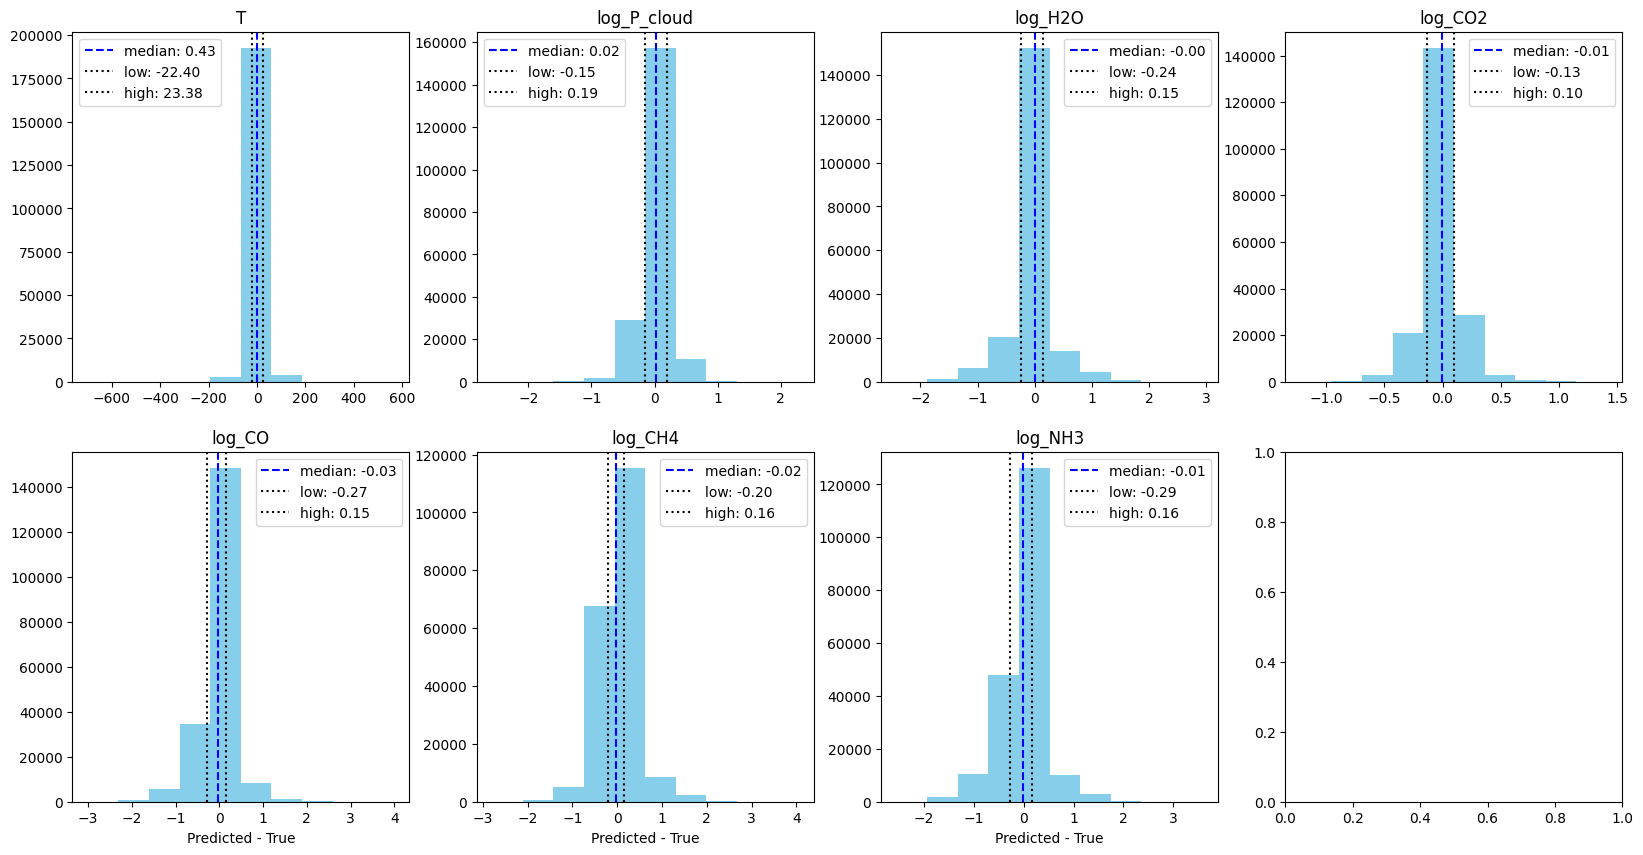

In [50]:
keys = ['T', 'log_P_cloud', 'log_H2O', 'log_CO2', 'log_CO', 'log_CH4', 'log_NH3']
fig, axs = plt.subplots(2, 4, figsize=(20,10))

y_test_rescaled = scaler.inverse_transform(y_test)
predictions = np.array(pred.cpu())
predictions = scaler.inverse_transform(predictions)

for i in range(7):
    if i < 4:
        pred_err = predictions[:,i]-y_test_rescaled[:,i]
        med = np.median(pred_err)
        low = np.percentile(pred_err,15.9)
        high = np.percentile(pred_err,84.1)
        axs[0,i].hist(pred_err,bins=10,color='skyblue')
        axs[0,i].axvline(x=med,color='blue',linestyle='--',label=f'median: {med:.2f}')
        axs[0,i].axvline(x=low,color='black',linestyle=':',label=f'low: {low:.2f}')
        axs[0,i].axvline(x=high,color='black',linestyle=':',label=f'high: {high:.2f}')
        axs[0,i].set_title(keys[i])
        axs[0,i].legend()
        #axs[0,i].set_xlabel('Predicted - True')
    else:
        pred_err = predictions[:,i]-y_test_rescaled[:,i]
        med = np.median(pred_err)
        low = np.percentile(pred_err,15.9)
        high = np.percentile(pred_err,84.1)
        axs[1,i-4].hist(pred_err,bins=10,color='skyblue')
        axs[1,i-4].axvline(x=med,color='blue',linestyle='--',label=f'median: {med:.2f}')
        axs[1,i-4].axvline(x=low,color='black',linestyle=':',label=f'low: {low:.2f}')
        axs[1,i-4].axvline(x=high,color='black',linestyle=':',label=f'high: {high:.2f}')
        axs[1,i-4].set_title(keys[i])
        axs[1,i-4].legend()
        axs[1,i-4].set_xlabel('Predicted - True')

In [51]:
y_test_rescaled_1M = scaler.inverse_transform(y_test)
predictions_1M = np.array(pred.cpu())
predictions_1M = scaler.inverse_transform(predictions_1M)

In [52]:
pred_data = torch.from_numpy(test_planets).float()
with torch.no_grad():
    pred_data = pred_data.to(device)
    pred = net_1m(pred_data)    
pred = np.array(pred.cpu())    
pred = scaler.inverse_transform(pred)
pred

array([[ 2.1008982e+03,  7.9010554e-02, -7.9497161e+00, -8.3298273e+00,
        -5.0664458e+00, -3.7572927e+00, -4.2170830e+00],
       [ 1.1283240e+03,  4.2080456e-01, -2.8392622e+00, -2.6349838e+00,
        -8.4866457e+00, -5.6940641e+00, -5.1610217e+00],
       [ 2.6875474e+03, -3.4245031e+00, -5.7269640e+00, -5.5141149e+00,
        -6.2851624e+00, -2.9648929e+00, -5.6433010e+00]], dtype=float32)

In [53]:
planetA_pred_1M = pred[0]
print("Predicted values:",planetA_pred_1M)
print("Actual values:",planetA_params[3:])

Predicted values: [ 2.1008982e+03  7.9010554e-02 -7.9497161e+00 -8.3298273e+00
 -5.0664458e+00 -3.7572927e+00 -4.2170830e+00]
Actual values: [ 2.08383676e+03 -1.94865038e-01 -7.35204337e+00 -8.11423364e+00
 -5.01872241e+00 -3.65232765e+00 -4.16874130e+00]


In [54]:
planetB_pred_1M = pred[1]
print("Predicted values:",planetB_pred_1M)
print("Actual values:",planetB_params[3:])

Predicted values: [ 1.1283240e+03  4.2080456e-01 -2.8392622e+00 -2.6349838e+00
 -8.4866457e+00 -5.6940641e+00 -5.1610217e+00]
Actual values: [ 1.11335948e+03  1.70457392e-01 -2.78129766e+00 -2.70422089e+00
 -8.81511155e+00 -5.79890730e+00 -5.21304883e+00]


In [55]:
planetC_pred_1M = pred[2]
print("Predicted values:",planetC_pred_1M)
print("Actual values:",planetC_params[3:])

Predicted values: [2687.5474      -3.424503    -5.726964    -5.514115    -6.2851624
   -2.9648929   -5.643301 ]
Actual values: [ 2.66055847e+03 -3.48554752e+00 -5.39606516e+00 -5.07833705e+00
 -5.97777151e+00 -2.57789940e+00 -5.33643891e+00]


## Comparison

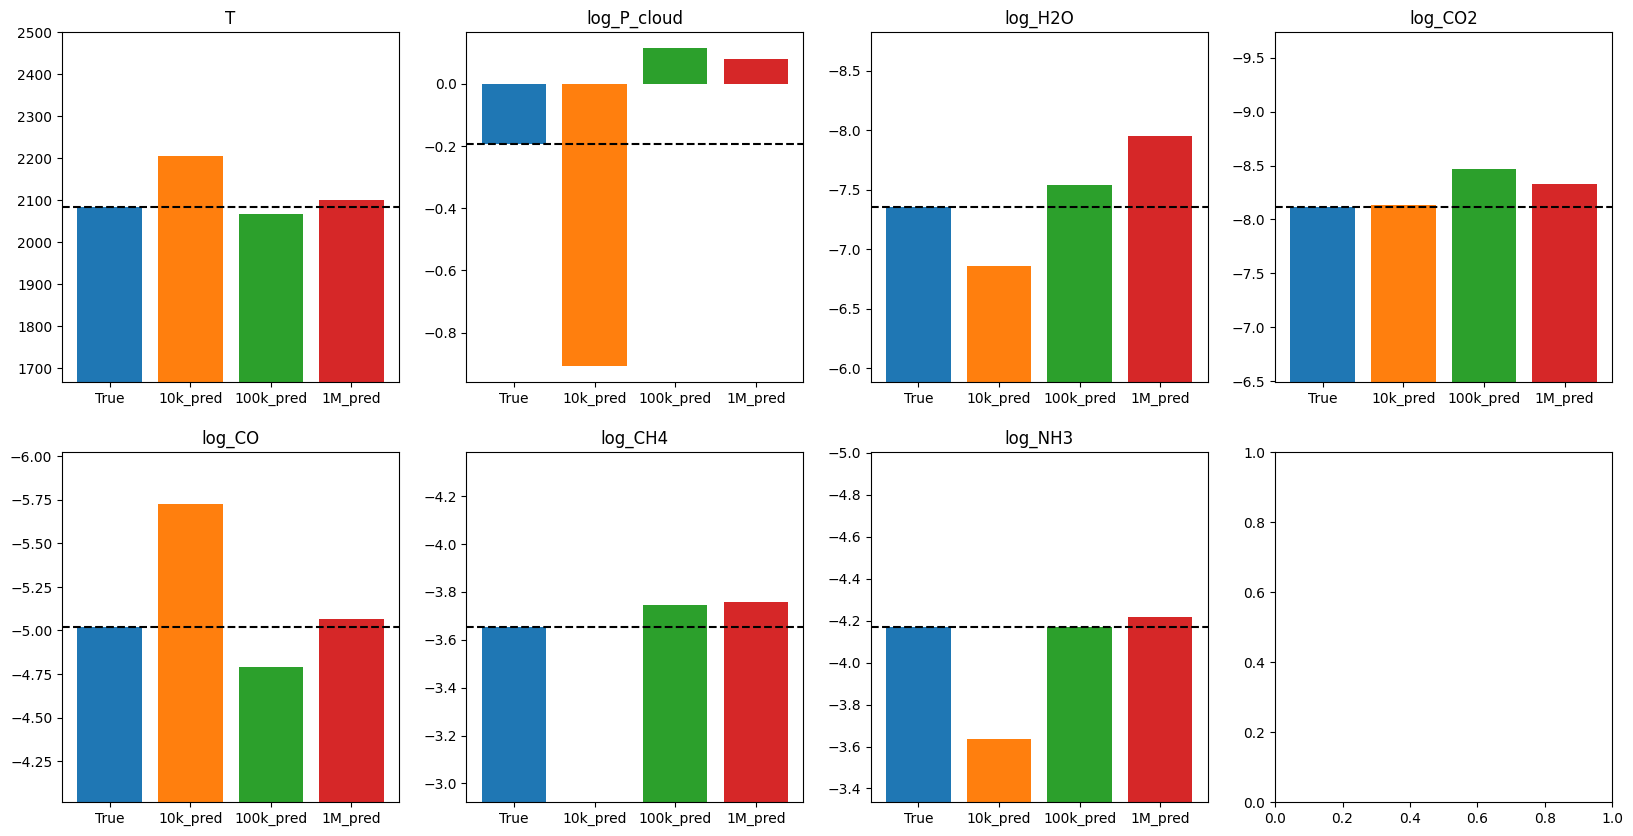

In [56]:
labels1 = ['True']
labels2 = ['10k_pred']
labels3 = ['100k_pred']
labels4 = ['1M_pred']
fig, axs = plt.subplots(2, 4, figsize=(20,10))

for i in range(7):
    if i < 2:
        axs[0,i].bar(labels1, planetA_params[3+i])
        axs[0,i].bar(labels2, planetA_pred_10k[i])
        axs[0,i].bar(labels3, planetA_pred_100k[i])
        axs[0,i].bar(labels4, planetA_pred_1M[i])
        axs[0,i].set_title(keys[i])
        axs[0,i].axhline(y=planetA_params[3+i],color='black', linestyle='--')
        axs[0,0].set_ylim(0.80*planetA_params[3],1.20*planetA_params[3])
    elif i<4 and i>1:
        axs[0,i].bar(labels1, planetA_params[3+i])
        axs[0,i].bar(labels2, planetA_pred_10k[i])
        axs[0,i].bar(labels3, planetA_pred_100k[i])
        axs[0,i].bar(labels4, planetA_pred_1M[i])
        axs[0,i].set_title(keys[i])
        axs[0,i].axhline(y=planetA_params[3+i],color='black', linestyle='--')
        axs[0,i].invert_yaxis()
        axs[0,i].set_ylim(0.80*planetA_params[3+i],1.20*planetA_params[3+i])
    else:
        axs[1,i-4].bar(labels1, planetA_params[3+i])
        axs[1,i-4].bar(labels2, planetA_pred_10k[i])
        axs[1,i-4].bar(labels3, planetA_pred_100k[i])
        axs[1,i-4].bar(labels4, planetA_pred_1M[i])
        axs[1,i-4].set_title(keys[i])
        axs[1,i-4].axhline(y=planetA_params[3+i],color='black', linestyle='--')
        axs[1,i-4].invert_yaxis()
        axs[1,i-4].set_ylim(0.80*planetA_params[3+i],1.20*planetA_params[3+i])
        
plt.savefig('comparison_plot1.png')

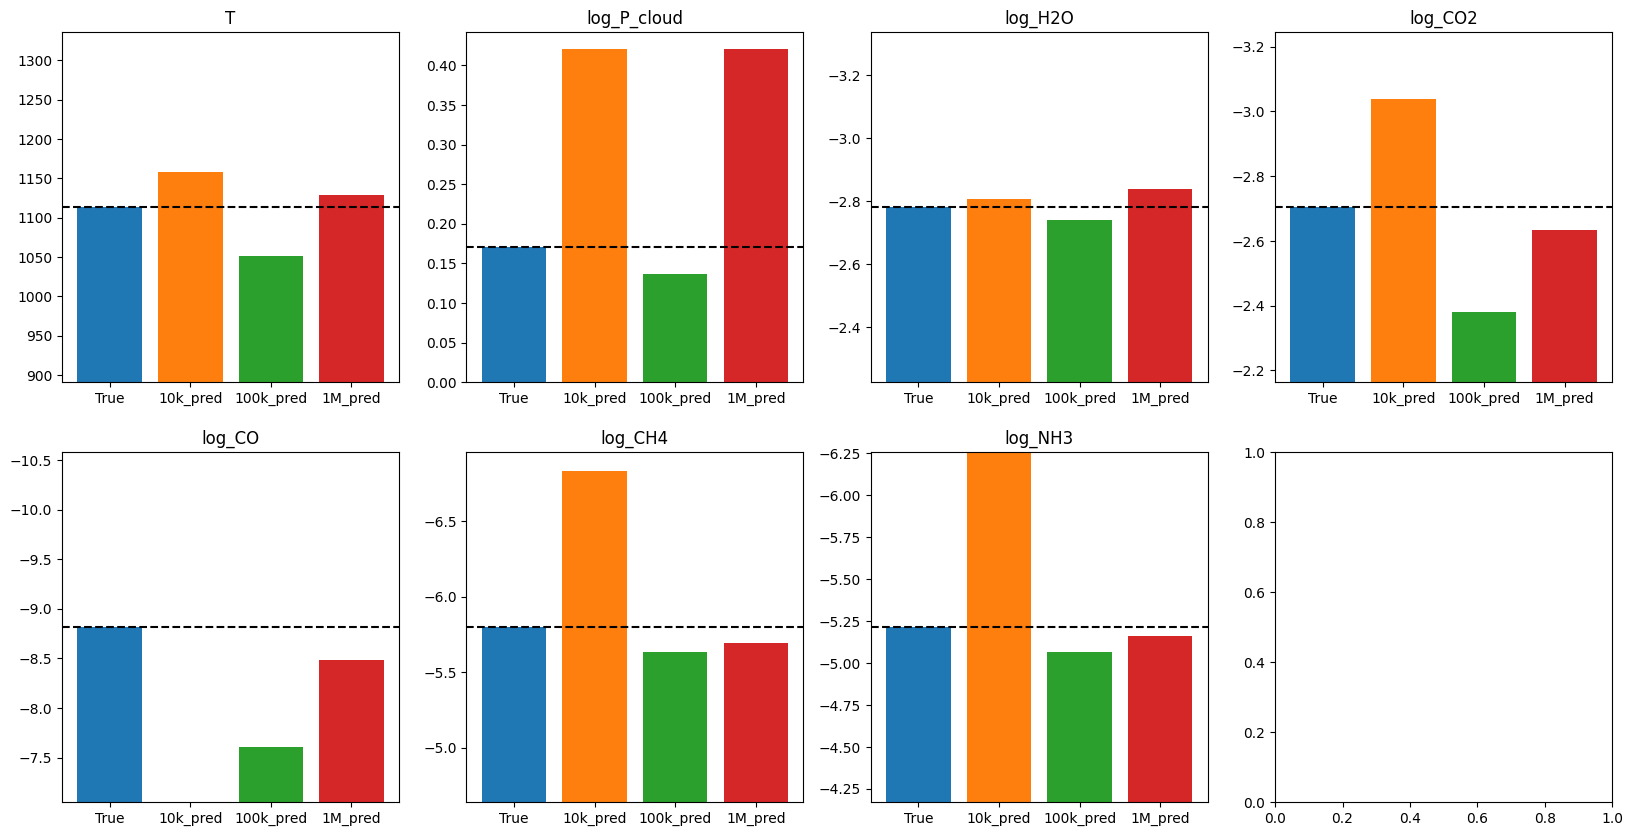

In [57]:
fig, axs = plt.subplots(2, 4, figsize=(20,10))

for i in range(7):
    if i < 2:
        axs[0,i].bar(labels1, planetB_params[3+i])
        axs[0,i].bar(labels2, planetB_pred_10k[i])
        axs[0,i].bar(labels3, planetB_pred_100k[i])
        axs[0,i].bar(labels4, planetB_pred_1M[i])
        axs[0,i].set_title(keys[i])
        axs[0,i].axhline(y=planetB_params[3+i],color='black', linestyle='--')
        axs[0,0].set_ylim(0.80*planetB_params[3],1.20*planetB_params[3])
    elif i<4 and i>1:
        axs[0,i].bar(labels1, planetB_params[3+i])
        axs[0,i].bar(labels2, planetB_pred_10k[i])
        axs[0,i].bar(labels3, planetB_pred_100k[i])
        axs[0,i].bar(labels4, planetB_pred_1M[i])
        axs[0,i].set_title(keys[i])
        axs[0,i].axhline(y=planetB_params[3+i],color='black', linestyle='--')
        axs[0,i].invert_yaxis()
        axs[0,i].set_ylim(0.80*planetB_params[3+i],1.20*planetB_params[3+i])
    else:
        axs[1,i-4].bar(labels1, planetB_params[3+i])
        axs[1,i-4].bar(labels2, planetB_pred_10k[i])
        axs[1,i-4].bar(labels3, planetB_pred_100k[i])
        axs[1,i-4].bar(labels4, planetB_pred_1M[i])
        axs[1,i-4].set_title(keys[i])
        axs[1,i-4].axhline(y=planetB_params[3+i],color='black', linestyle='--')
        axs[1,i-4].invert_yaxis()
        axs[1,i-4].set_ylim(0.80*planetB_params[3+i],1.20*planetB_params[3+i])
        
plt.savefig('comparison_plot2.png')

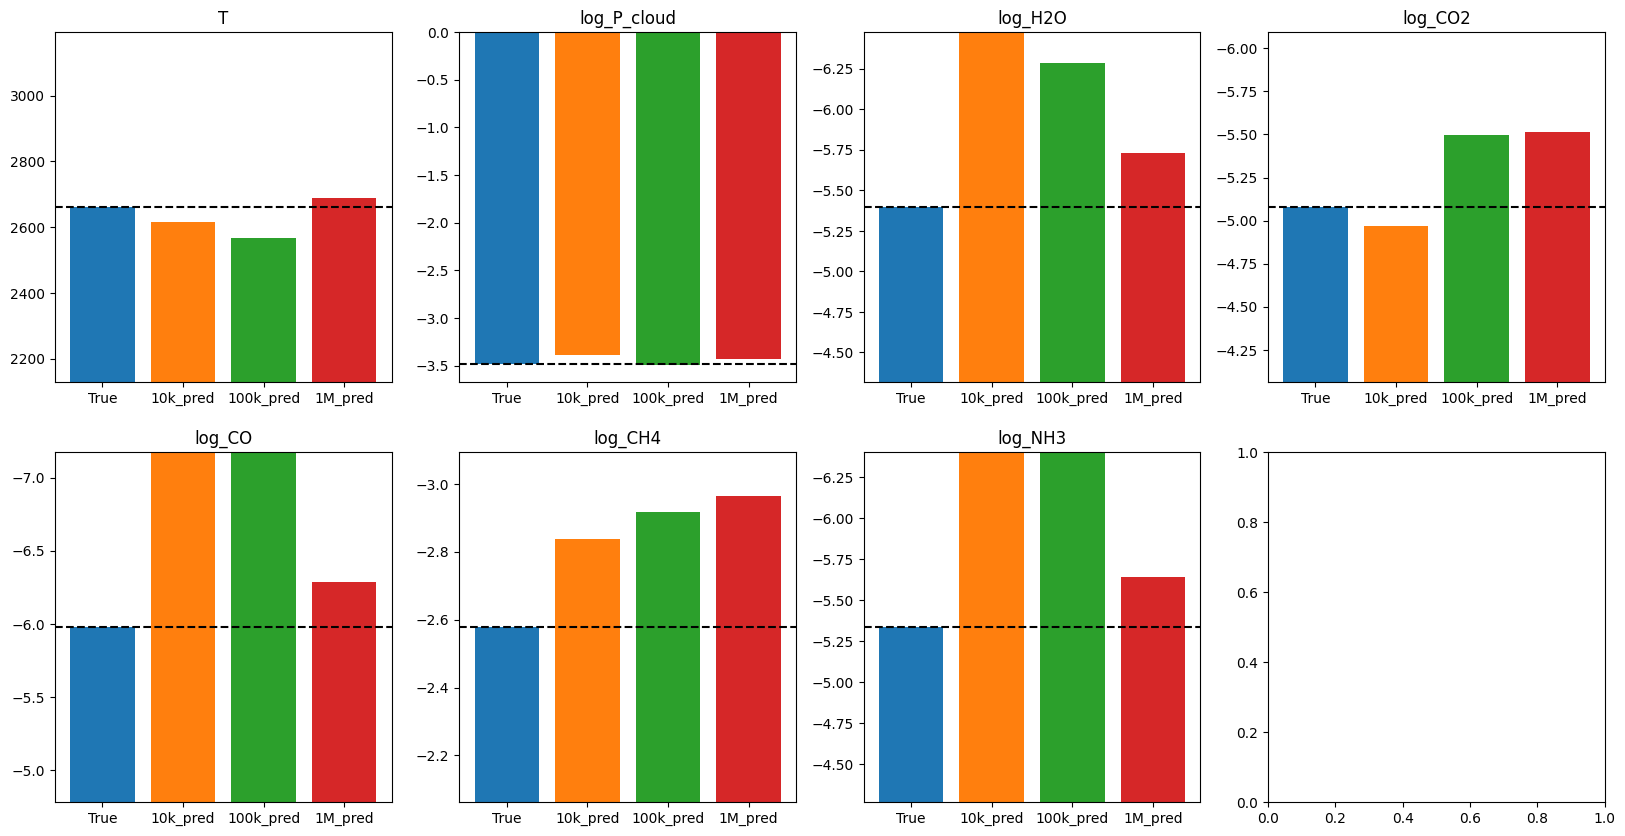

In [58]:
fig, axs = plt.subplots(2, 4, figsize=(20,10))
for i in range(7):
    if i < 2:
        axs[0,i].bar(labels1, planetC_params[3+i])
        axs[0,i].bar(labels2, planetC_pred_10k[i])
        axs[0,i].bar(labels3, planetC_pred_100k[i])
        axs[0,i].bar(labels4, planetC_pred_1M[i])
        axs[0,i].set_title(keys[i])
        axs[0,i].axhline(y=planetC_params[3+i],color='black', linestyle='--')
        axs[0,0].set_ylim(0.80*planetC_params[3],1.20*planetC_params[3])
    elif i<4 and i>1:
        axs[0,i].bar(labels1, planetC_params[3+i])
        axs[0,i].bar(labels2, planetC_pred_10k[i])
        axs[0,i].bar(labels3, planetC_pred_100k[i])
        axs[0,i].bar(labels4, planetC_pred_1M[i])
        axs[0,i].set_title(keys[i])
        axs[0,i].axhline(y=planetC_params[3+i],color='black', linestyle='--')
        axs[0,i].invert_yaxis()
        axs[0,i].set_ylim(0.80*planetC_params[3+i],1.20*planetC_params[3+i])
    else:
        axs[1,i-4].bar(labels1, planetC_params[3+i])
        axs[1,i-4].bar(labels2, planetC_pred_10k[i])
        axs[1,i-4].bar(labels3, planetC_pred_100k[i])
        axs[1,i-4].bar(labels4, planetC_pred_1M[i])
        axs[1,i-4].set_title(keys[i])
        axs[1,i-4].axhline(y=planetC_params[3+i],color='black', linestyle='--')
        axs[1,i-4].invert_yaxis()
        axs[1,i-4].set_ylim(0.80*planetC_params[3+i],1.20*planetC_params[3+i])
        
plt.savefig('comparison_plot3.png')

## Error histograms

In [59]:
y_test_rescaled_10k.shape, predictions_10k.shape

((2000, 7), (2000, 7))

In [60]:
y_test_rescaled_100k.shape, predictions_100k.shape

((20000, 7), (20000, 7))

In [61]:
y_test_rescaled_1M.shape, predictions_1M.shape

((199195, 7), (199195, 7))

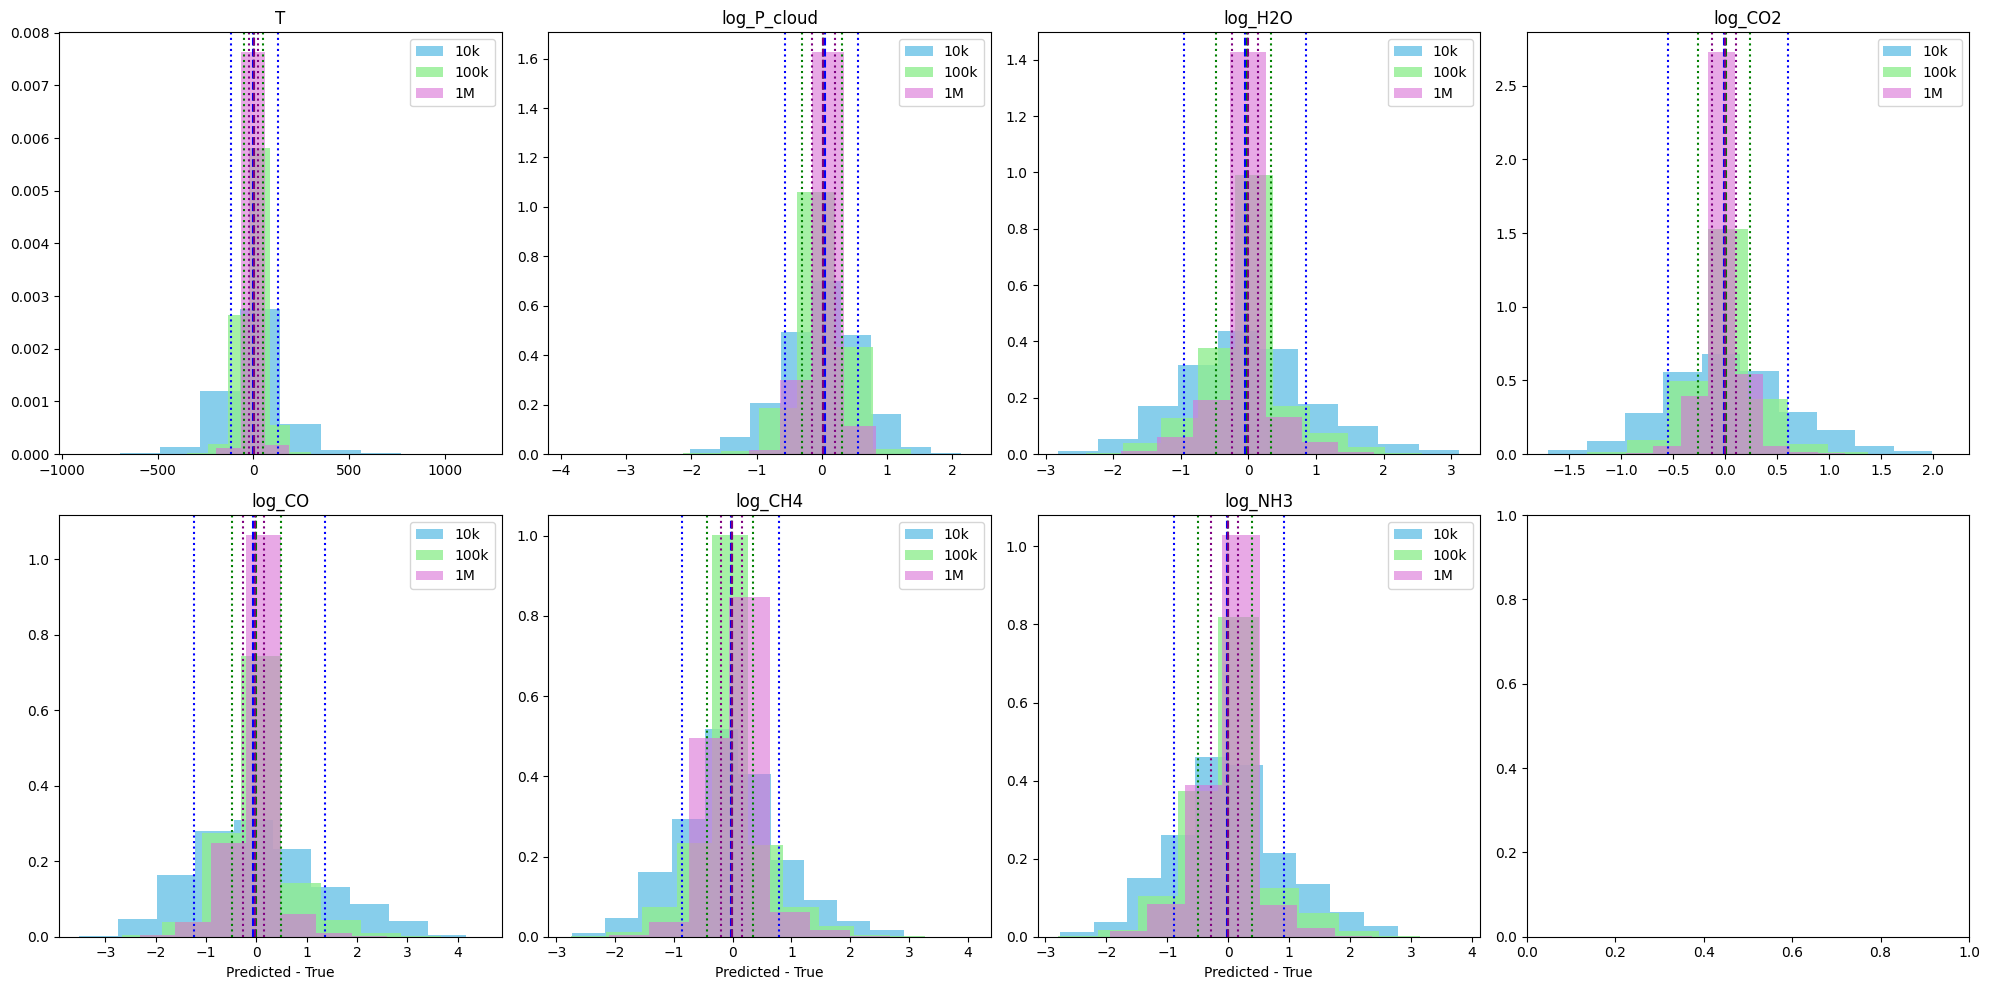

In [62]:
keys = ['T', 'log_P_cloud', 'log_H2O', 'log_CO2', 'log_CO', 'log_CH4', 'log_NH3']
fig, axs = plt.subplots(2, 4, figsize=(20,10))
for i in range(7):
    if i < 4:
        pred_err_10k = predictions_10k[:,i]-y_test_rescaled_10k[:,i]
        pred_err_100k = predictions_100k[:,i]-y_test_rescaled_100k[:,i]
        pred_err_1M = predictions_1M[:,i]-y_test_rescaled_1M[:,i]
        low_10k, med_10k, high_10k = np.percentile(pred_err_10k,(15.9,50,84.1))
        low_100k, med_100k, high_100k = np.percentile(pred_err_100k,(15.9,50,84.1))
        low_1M, med_1M, high_1M = np.percentile(pred_err_1M,(15.9,50,84.1))
        
        axs[0,i].hist(pred_err_10k,bins=10,color='skyblue',label='10k',density=True)
        axs[0,i].axvline(x=med_10k,color='blue',linestyle='--')
        axs[0,i].axvline(x=low_10k,color='blue',linestyle=':')
        axs[0,i].axvline(x=high_10k,color='blue',linestyle=':')

        axs[0,i].hist(pred_err_100k,bins=10,color='lightgreen',label='100k',density=True,alpha=0.8)
        axs[0,i].axvline(x=med_100k,color='green',linestyle='--')
        axs[0,i].axvline(x=low_100k,color='green',linestyle=':')
        axs[0,i].axvline(x=high_100k,color='green',linestyle=':')

        axs[0,i].hist(pred_err_1M,bins=10,color='orchid',label='1M',density=True,alpha=0.6)
        axs[0,i].axvline(x=med_1M,color='purple',linestyle='--')
        axs[0,i].axvline(x=low_1M,color='purple',linestyle=':')
        axs[0,i].axvline(x=high_1M,color='purple',linestyle=':')
        axs[0,i].set_title(keys[i])
        axs[0,i].legend()
        #axs[0,i].set_xlabel('Predicted - True')
    else:
        pred_err_10k = predictions_10k[:,i]-y_test_rescaled_10k[:,i]
        pred_err_100k = predictions_100k[:,i]-y_test_rescaled_100k[:,i]
        pred_err_1M = predictions_1M[:,i]-y_test_rescaled_1M[:,i]
        low_10k, med_10k, high_10k = np.percentile(pred_err_10k,(15.9,50,84.1))
        low_100k, med_100k, high_100k = np.percentile(pred_err_100k,(15.9,50,84.1))
        low_1M, med_1M, high_1M = np.percentile(pred_err_1M,(15.9,50,84.1))
        
        axs[1,i-4].hist(pred_err_10k,bins=10,color='skyblue',label='10k',density=True)
        axs[1,i-4].axvline(x=med_10k,color='blue',linestyle='--')
        axs[1,i-4].axvline(x=low_10k,color='blue',linestyle=':')
        axs[1,i-4].axvline(x=high_10k,color='blue',linestyle=':')

        axs[1,i-4].hist(pred_err_100k,bins=10,color='lightgreen',label='100k',density=True,alpha=0.8)
        axs[1,i-4].axvline(x=med_100k,color='green',linestyle='--')
        axs[1,i-4].axvline(x=low_100k,color='green',linestyle=':')
        axs[1,i-4].axvline(x=high_100k,color='green',linestyle=':')

        axs[1,i-4].hist(pred_err_1M,bins=10,color='orchid',label='1M',density=True,alpha=0.6)
        axs[1,i-4].axvline(x=med_1M,color='purple',linestyle='--')
        axs[1,i-4].axvline(x=low_1M,color='purple',linestyle=':')
        axs[1,i-4].axvline(x=high_1M,color='purple',linestyle=':')
        axs[1,i-4].set_title(keys[i])
        axs[1,i-4].legend()
        axs[1,i-4].set_xlabel('Predicted - True')
plt.tight_layout()
plt.savefig('error_histograms1.png')

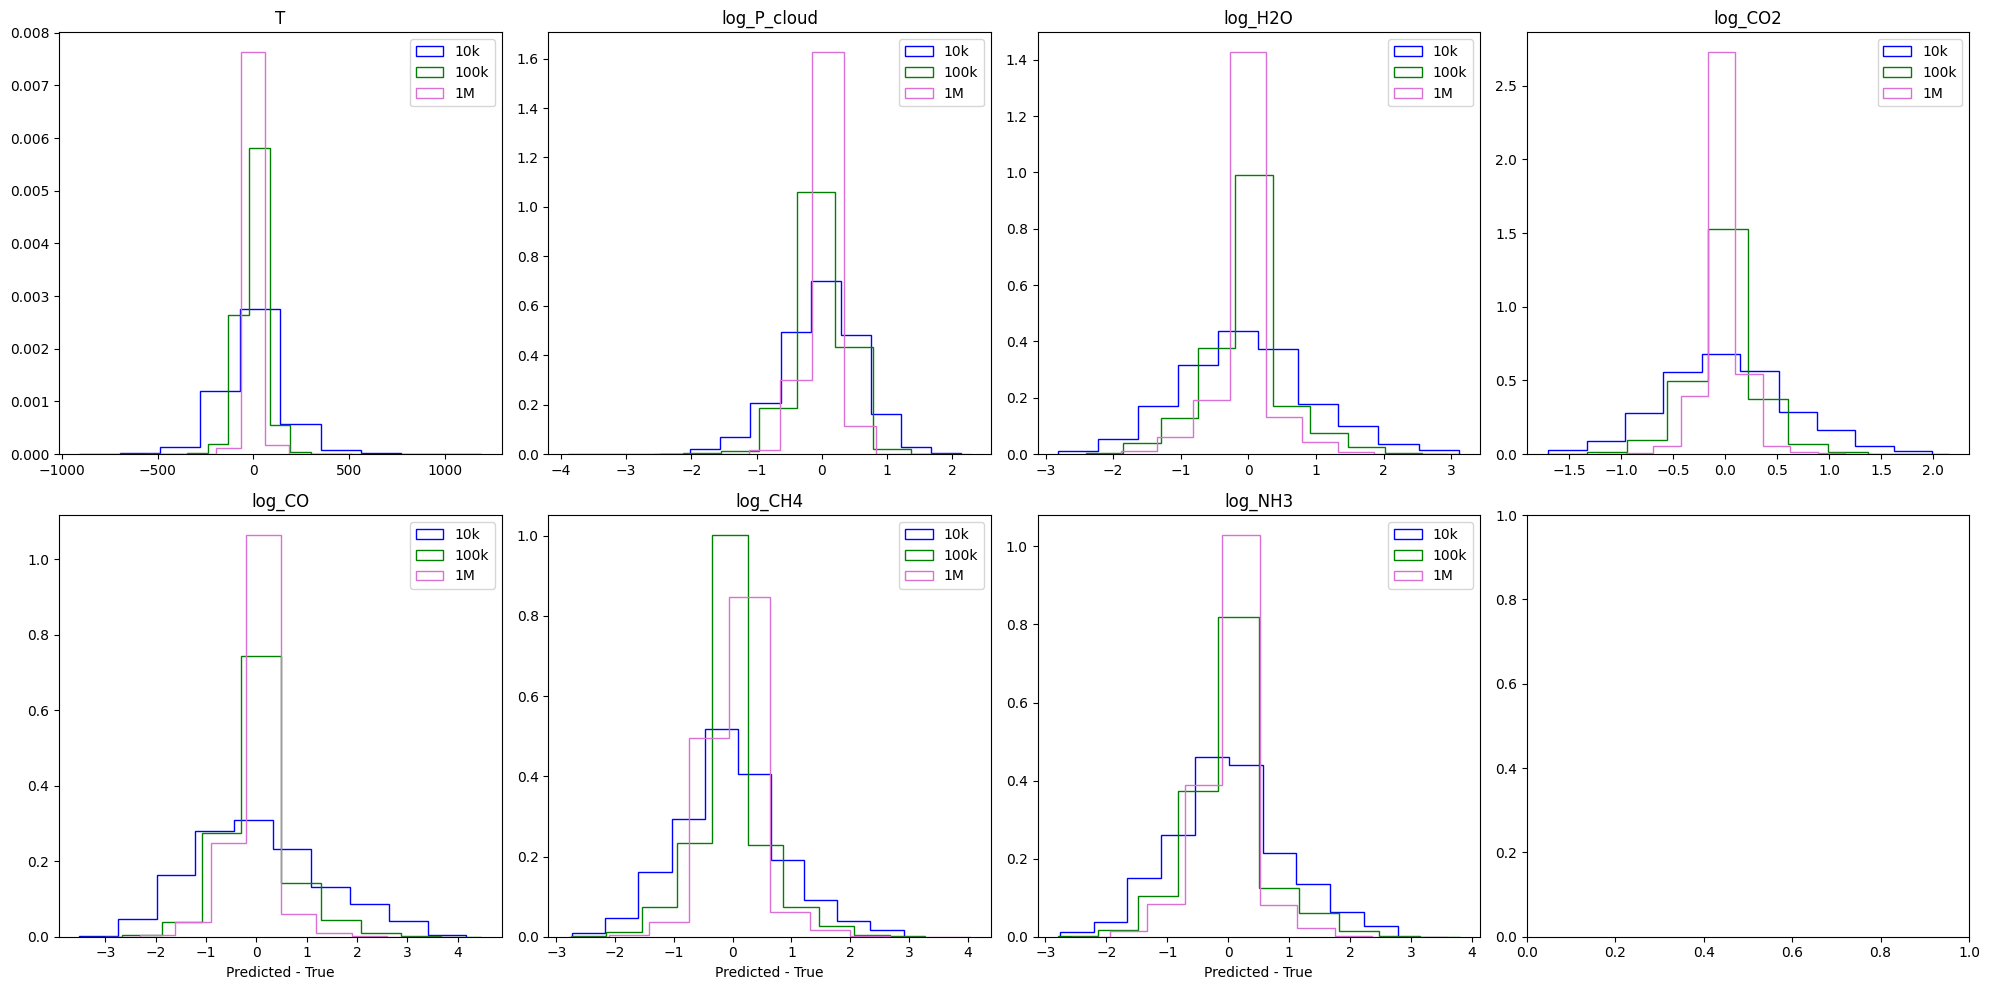

In [63]:
keys = ['T', 'log_P_cloud', 'log_H2O', 'log_CO2', 'log_CO', 'log_CH4', 'log_NH3']
fig, axs = plt.subplots(2, 4, figsize=(20,10))
for i in range(7):
    if i < 4:
        pred_err_10k = predictions_10k[:,i]-y_test_rescaled_10k[:,i]
        pred_err_100k = predictions_100k[:,i]-y_test_rescaled_100k[:,i]
        pred_err_1M = predictions_1M[:,i]-y_test_rescaled_1M[:,i]
        low_10k, med_10k, high_10k = np.percentile(pred_err_10k,(15.9,50,84.1))
        low_100k, med_100k, high_100k = np.percentile(pred_err_100k,(15.9,50,84.1))
        low_1M, med_1M, high_1M = np.percentile(pred_err_1M,(15.9,50,84.1))
        
        axs[0,i].hist(pred_err_10k,bins=10,color='blue',label='10k',density=True,histtype='step')
    
        axs[0,i].hist(pred_err_100k,bins=10,color='green',label='100k',density=True,histtype='step')
        

        axs[0,i].hist(pred_err_1M,bins=10,color='orchid',label='1M',density=True,histtype='step')

        axs[0,i].set_title(keys[i])
        axs[0,i].legend()
        #axs[0,i].set_xlabel('Predicted - True')
    else:
        pred_err_10k = predictions_10k[:,i]-y_test_rescaled_10k[:,i]
        pred_err_100k = predictions_100k[:,i]-y_test_rescaled_100k[:,i]
        pred_err_1M = predictions_1M[:,i]-y_test_rescaled_1M[:,i]
        low_10k, med_10k, high_10k = np.percentile(pred_err_10k,(15.9,50,84.1))
        low_100k, med_100k, high_100k = np.percentile(pred_err_100k,(15.9,50,84.1))
        low_1M, med_1M, high_1M = np.percentile(pred_err_1M,(15.9,50,84.1))
        
        axs[1,i-4].hist(pred_err_10k,bins=10,color='blue',label='10k',density=True,histtype='step')


        axs[1,i-4].hist(pred_err_100k,bins=10,color='green',label='100k',density=True,histtype='step')


        axs[1,i-4].hist(pred_err_1M,bins=10,color='orchid',label='1M',density=True,histtype='step')

        axs[1,i-4].set_title(keys[i])
        axs[1,i-4].legend()
        axs[1,i-4].set_xlabel('Predicted - True')
plt.tight_layout()
plt.savefig('error_histograms2.png')